In [1]:
import numpy as np
from matplotlib import pyplot as plt
import sys, os
sys.path.insert(1, '../quantarhei')
sys.path.insert(2, '../spectre')
import quantarhei as qr
import spectre
import spectre.full as sef
import spectre.spectroscopy.abs_spectroscopy as abss

# (1.) First version - step (s2)

In [2]:
path = 'C:/Users/micha/Documents/Studium/MScThesis/data-meta/E-scanopt-pyr06-1mode/results_E-pyr06-1mode-P-177_scanopt_01_2023-07-07_17-36-22'
path = 'C:/Users/micha/Documents/Studium/MScThesis/data-meta/E-scanopt-pyr06-1mode/results_E-pyr06-1mode-P-177_scanopt_01_2023-07-07_17-36-22'

In [3]:
files = [file for file in os.listdir(path) if file.endswith('.json') and file.startswith('opt')]
sfiles = sorted(files, key=lambda s: float(s.split('.')[0].split('_')[2]))

C:\Users\micha\AppData\Local\Temp\ipykernel_30028\814600582.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  clm = cm.get_cmap('viridis', len(files))
C:\Users\micha\AppData\Local\Temp\ipykernel_30028\814600582.py:32: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, orientation='horizontal')


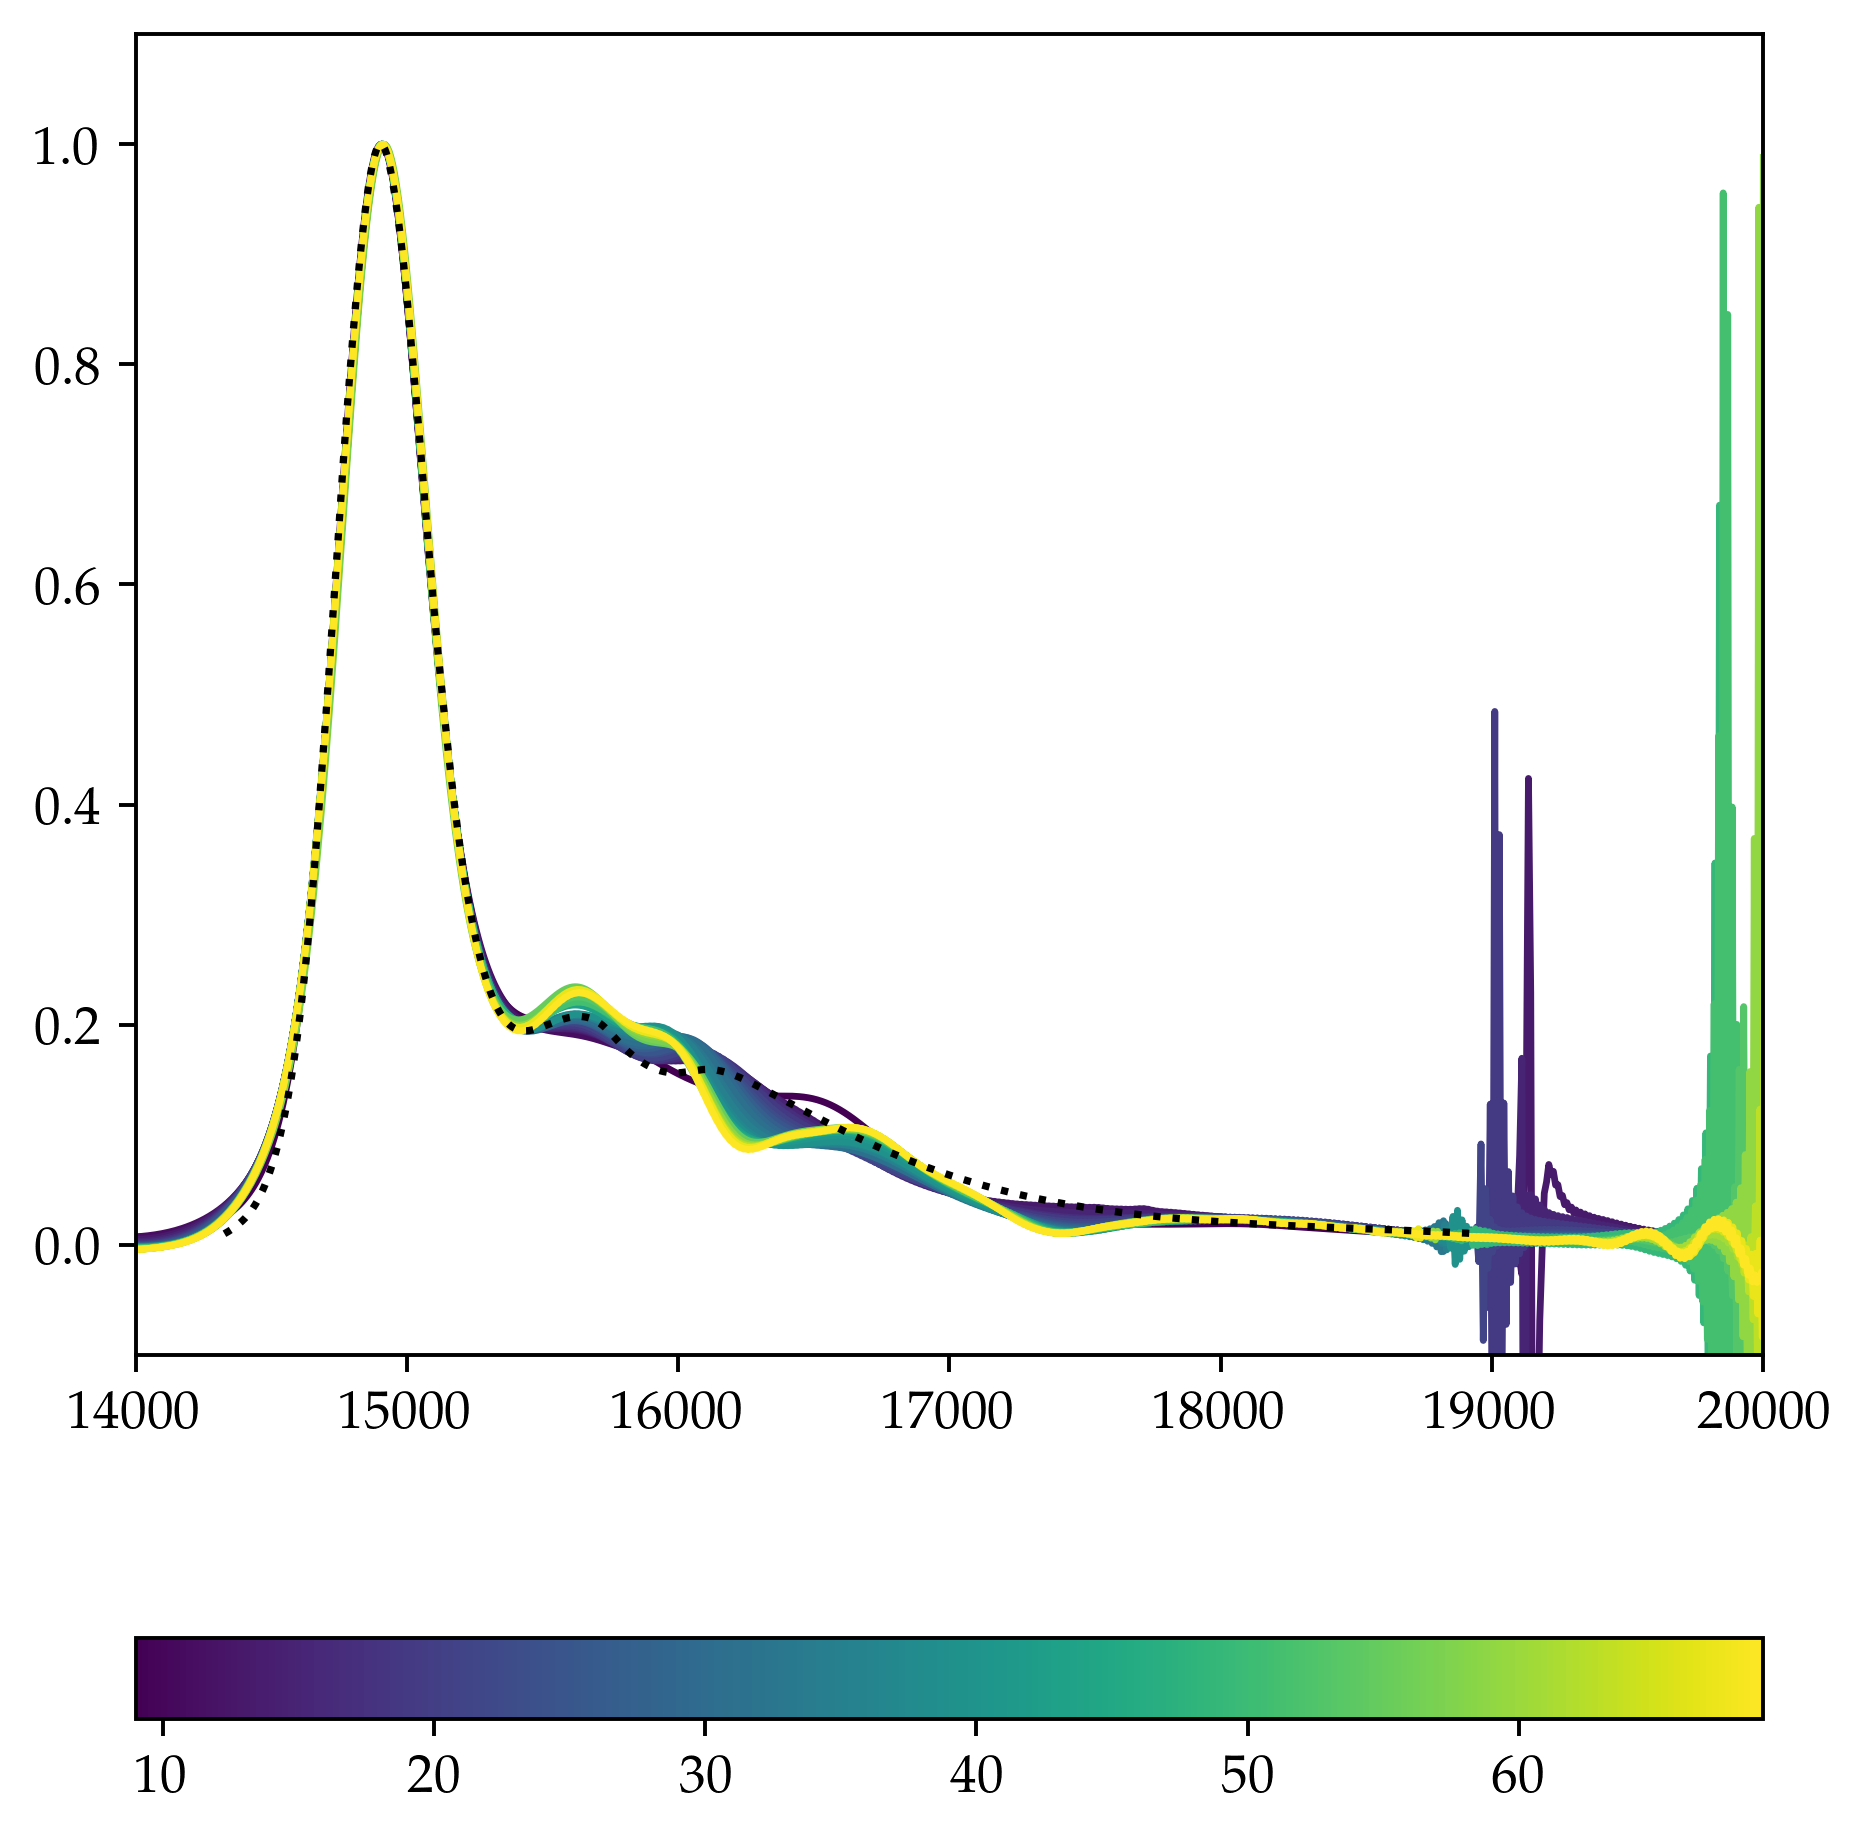

In [9]:
from matplotlib import cm
clm = cm.get_cmap('viridis', len(files))

fig, ax = plt.subplots(figsize=(6,7), dpi= 350)
labels = list()

for i, f in enumerate(sfiles[:]):
    filepath = os.path.join(path, f)
    optpars = spectre.utils.loadjson(filepath)
    datapath = filepath.replace('.json', '.npy')
    
    if os.path.isfile(datapath):
        data = np.load(datapath)
    else:
        syst, ta = spectre.full.init_system(optpars)
        spec = abss.calculate_abs_spectrum(syst, ta, optpars)
        spec.normalize()
        
        with qr.energy_units('1/cm'):
            data = np.vstack([spec.axis.data, spec.data])
            np.save(datapath, data)

    lab = f.split('.')[0].split('_')[2]
    plt.plot(data[0], data[1], label=lab, linewidth=1.4, color=clm(i))
    labels.append(lab)

plt.xlim(14000, 20000)
plt.ylim(-0.1, 1.1)
#plt.legend(frameon=False)

sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(labels[0], labels[-1]))
cbar = plt.colorbar(sm, orientation='horizontal')
#cbar.set_ticklabels(labs)

abss.plot_ref(6, plot_to=ax, color='k', linestyle = 'dotted')

C:\Users\micha\AppData\Local\Temp\ipykernel_30028\515961166.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  clm = cm.get_cmap('viridis', len(files))
C:\Users\micha\AppData\Local\Temp\ipykernel_30028\515961166.py:18: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax0 = plt.subplot(gs[3])


Text(0, 0.5, 'residuum')

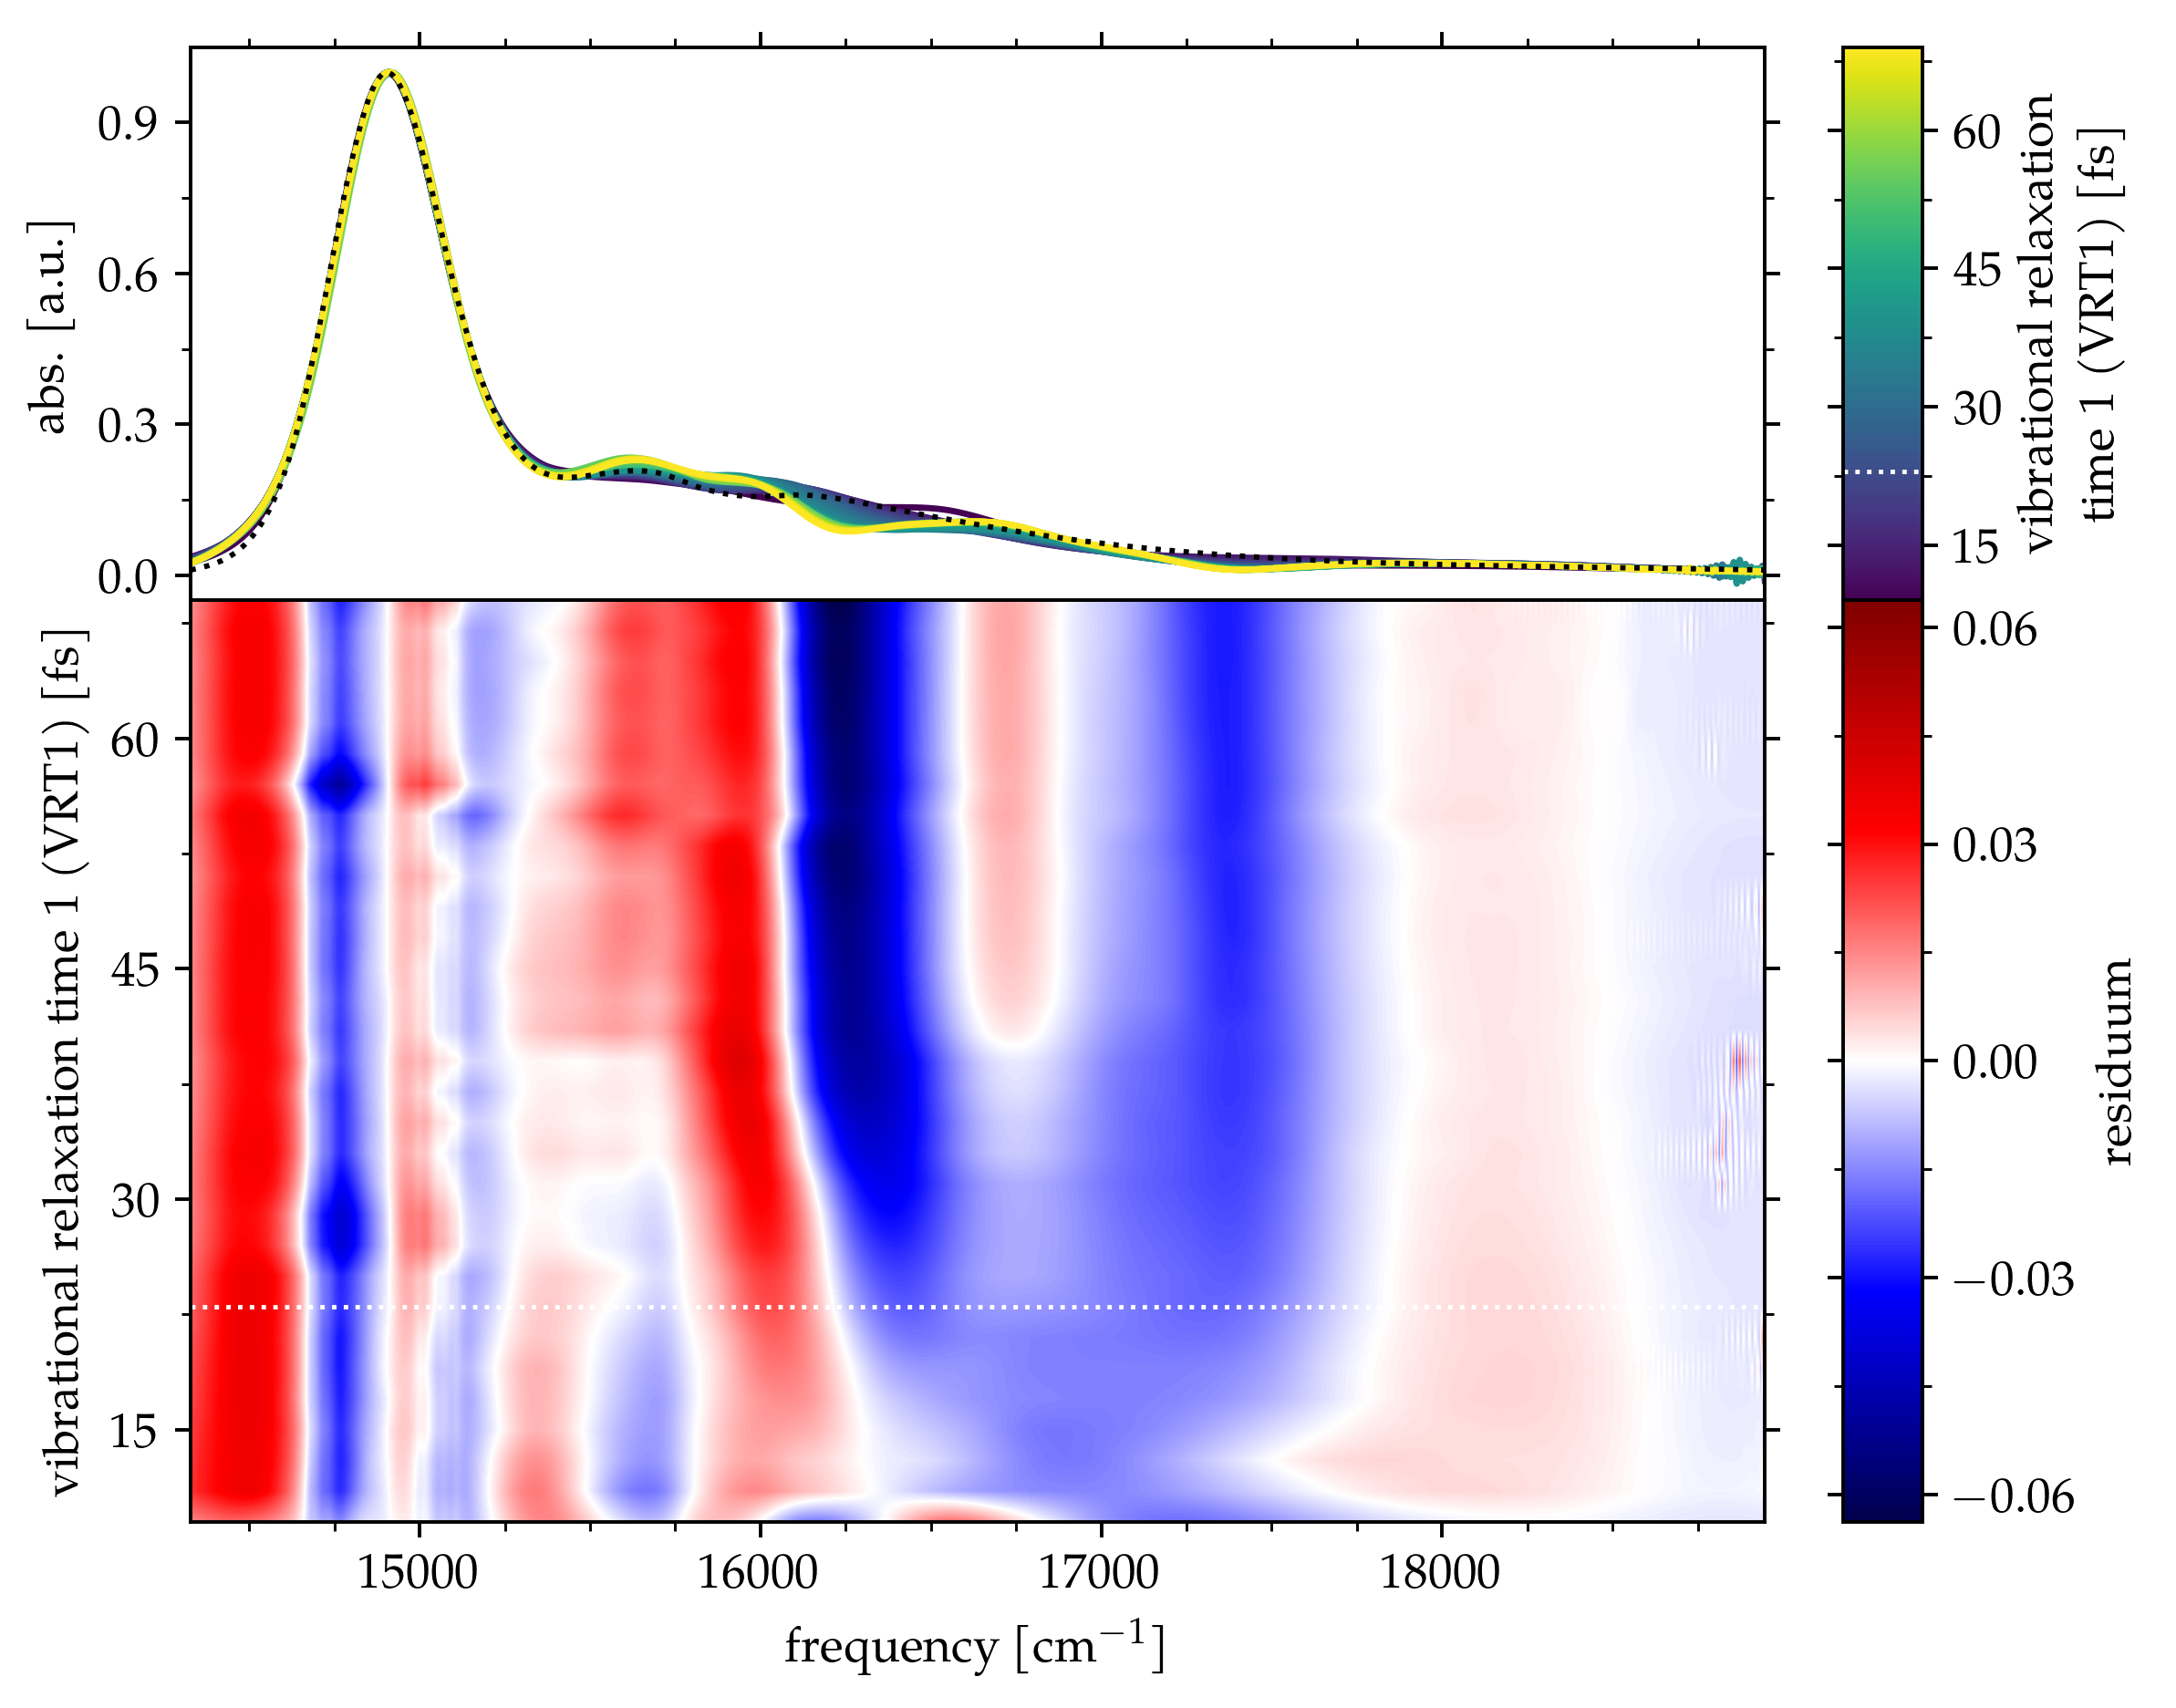

In [11]:
from matplotlib import cm
from scipy.interpolate import UnivariateSpline
from tqdm import tqdm
from matplotlib import gridspec

spline_s=0.0002
spline_k=3
ref_id = 6

clm = cm.get_cmap('viridis', len(files))

refdata = abss.plot_ref(ref_id, return_data='data', plot=False)
refx, refy = refdata

fig, ax = plt.subplots(num=None, figsize=(7,6), dpi=350, facecolor='w', edgecolor='k')
gs = gridspec.GridSpec(nrows=2, ncols=3, width_ratios=(1, 0.05, 0.05), height_ratios=(0.6, 1), figure=fig) 
#ax3 = plt.subplot(gs[3])
ax0 = plt.subplot(gs[3])
ax1 = plt.subplot(gs[0], sharex = ax0)
ax4 = plt.subplot(gs[5])
ax2 = plt.subplot(gs[2])
plt.subplots_adjust(hspace=0, wspace=0)

####################
#   ax1   #  # ax2 #
####################
#   ax0   #  # ax4 #
####################

all_data_filename = 'all_data.npy'
all_data_path = os.path.join(path, all_data_filename)

if os.path.isfile(all_data_path) and True:
    x, y, zdata = np.load(all_data_path)

    for i, z in enumerate(zdata):
        ax1.plot(x[i], z, linewidth=1.4, color=clm(i))
    
    zax = zdata - refy

else:
    labels = list()
    zax = None
    zdata = None
    i = 0

    for f in tqdm(sfiles[:]):
        i += 1
        filepath = os.path.join(path, f)
        optpars = spectre.utils.loadjson(filepath)
        datapath = filepath.replace('.json', '.npy')
        
        if os.path.isfile(datapath):
            data = np.load(datapath)
        else:
            syst, ta = spectre.full.init_system(optpars)
            spec = abss.calculate_abs_spectrum(syst, ta, optpars)
            spec.normalize()
            
            with qr.energy_units('1/cm'):
                data = np.vstack([spec.axis.data, spec.data])
                np.save(datapath, data)
    
        lab = f.split('.')[0].split('_')[2]
        spline = UnivariateSpline(*data, k=spline_k, s=spline_s)
        ydat = spline(refx) - refy
        
        if zax is None:
            zax = ydat
            zdata = spline(refx)
        else:
            zax = np.vstack([zax, ydat])
            zdata = np.vstack([zdata, spline(refx)])
        
        ax1.plot(data[0], data[1], label=lab, linewidth=1.4, color=clm(i))
        labels.append(float(lab))

    yax = np.array(labels)
    xax = refx
    x, y = np.meshgrid(xax, yax)
    np.save(all_data_path, np.array([x, y, zdata]))

maximum = np.abs(zax).max()

cf = ax0.contourf(x, y, zax, 500, cmap="seismic", vmax=maximum, vmin=-maximum)

#CS = ax0.contour(x, y, zax, 5)
#ax0.clabel(CS, inline=True, fontsize=10)

sm = plt.cm.ScalarMappable(cmap='seismic', norm=plt.Normalize(-maximum, maximum))
cbar = plt.colorbar(sm, cax=ax4, orientation='vertical')

sm2 = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(y[0,0], y[-1,0]))
cbar2 = plt.colorbar(sm2, cax=ax2, orientation='vertical')

ax0.plot([x[0,0], x[0,-1]], [23,23], linewidth=1, linestyle='dotted', c='w')
ax2.plot([0, 1], [23,23], linewidth=1, linestyle='dotted', c='w')

abss.plot_ref(ref_id, plot_to=ax1, linestyle='dotted', c='k', linewidth=1.2)

from matplotlib.ticker import MultipleLocator, AutoMinorLocator, MaxNLocator

for g in [ax0, ax1, ax2, ax4]:
    pars = dict(labelbottom=False, labeltop=False, labelleft=True, labelright=False,
                bottom=True,           top=True,      left=True,      right=True,)
    g.tick_params(which='both', **pars)
    
    #g.xaxis.set_major_locator(MultipleLocator(20))
    #g.xaxis.set_major_formatter('{x:.0f}')
    #g.xaxis.set_minor_locator(MultipleLocator(10))
    g.yaxis.set_major_locator(MaxNLocator(nbins=4))
    g.yaxis.set_minor_locator(AutoMinorLocator(2))
    g.xaxis.set_minor_locator(AutoMinorLocator(4))
    #g.ticklabel_format(style='sci', axis='y', scilimits=(-1,3), useOffset=True)

    #g.get_yaxis().set_offset_position("left")
    #g.get_yaxis().OFFSETTEXTPAD = 7
    #g.get_yaxis().get_offset_text().set_position((-0.097,0))

ax4.yaxis.set_major_locator(MaxNLocator(nbins=5))

ax0.tick_params(which='both', labelbottom=True, labelleft=True)
ax1.tick_params(which='both', bottom=False)
ax2.tick_params(which='both', labelleft=False, labelright=True)
ax4.tick_params(which='both', labelleft=False, labelright=True)

ax0.set_xlim(x[0,0], x[0,-1])
ax1.set_ylim(-0.05, 1.05)

ax0.set_xlabel(r'frequency [cm$^{-1}$]')
ax0.set_ylabel(r'vibrational relaxation time 1 (VRT1) [fs]')
ax1.set_ylabel(r'abs. [a.u.]')
ax2.set_ylabel(r'\parbox{40mm}{\centering vibrational relaxation time 1 (VRT1) [fs]}')
ax4.set_ylabel(r'residuum')

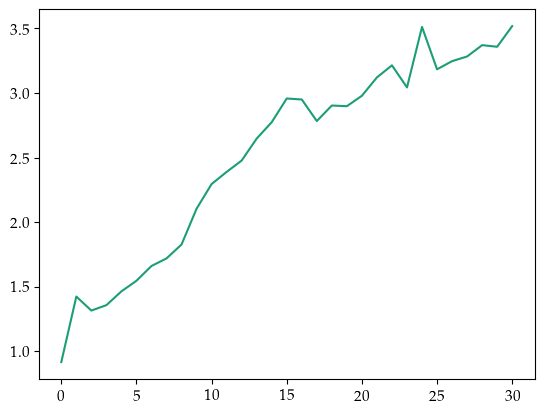

In [6]:
plt.plot((zax**2).sum(axis=1))

In [7]:
def draw_line(plot_to, xaxis, *vals, **pars):
    for val in vals:
        plot_to.plot([xaxis[0]-10, xaxis[-1]+10], [val, val], **pars)

C:\Users\micha\AppData\Local\Temp\ipykernel_30028\307295748.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  clm = cm.get_cmap('viridis', len(files))


Text(0.5, 0, 'vibrational relaxation time 1 (VRT1) [fs]')

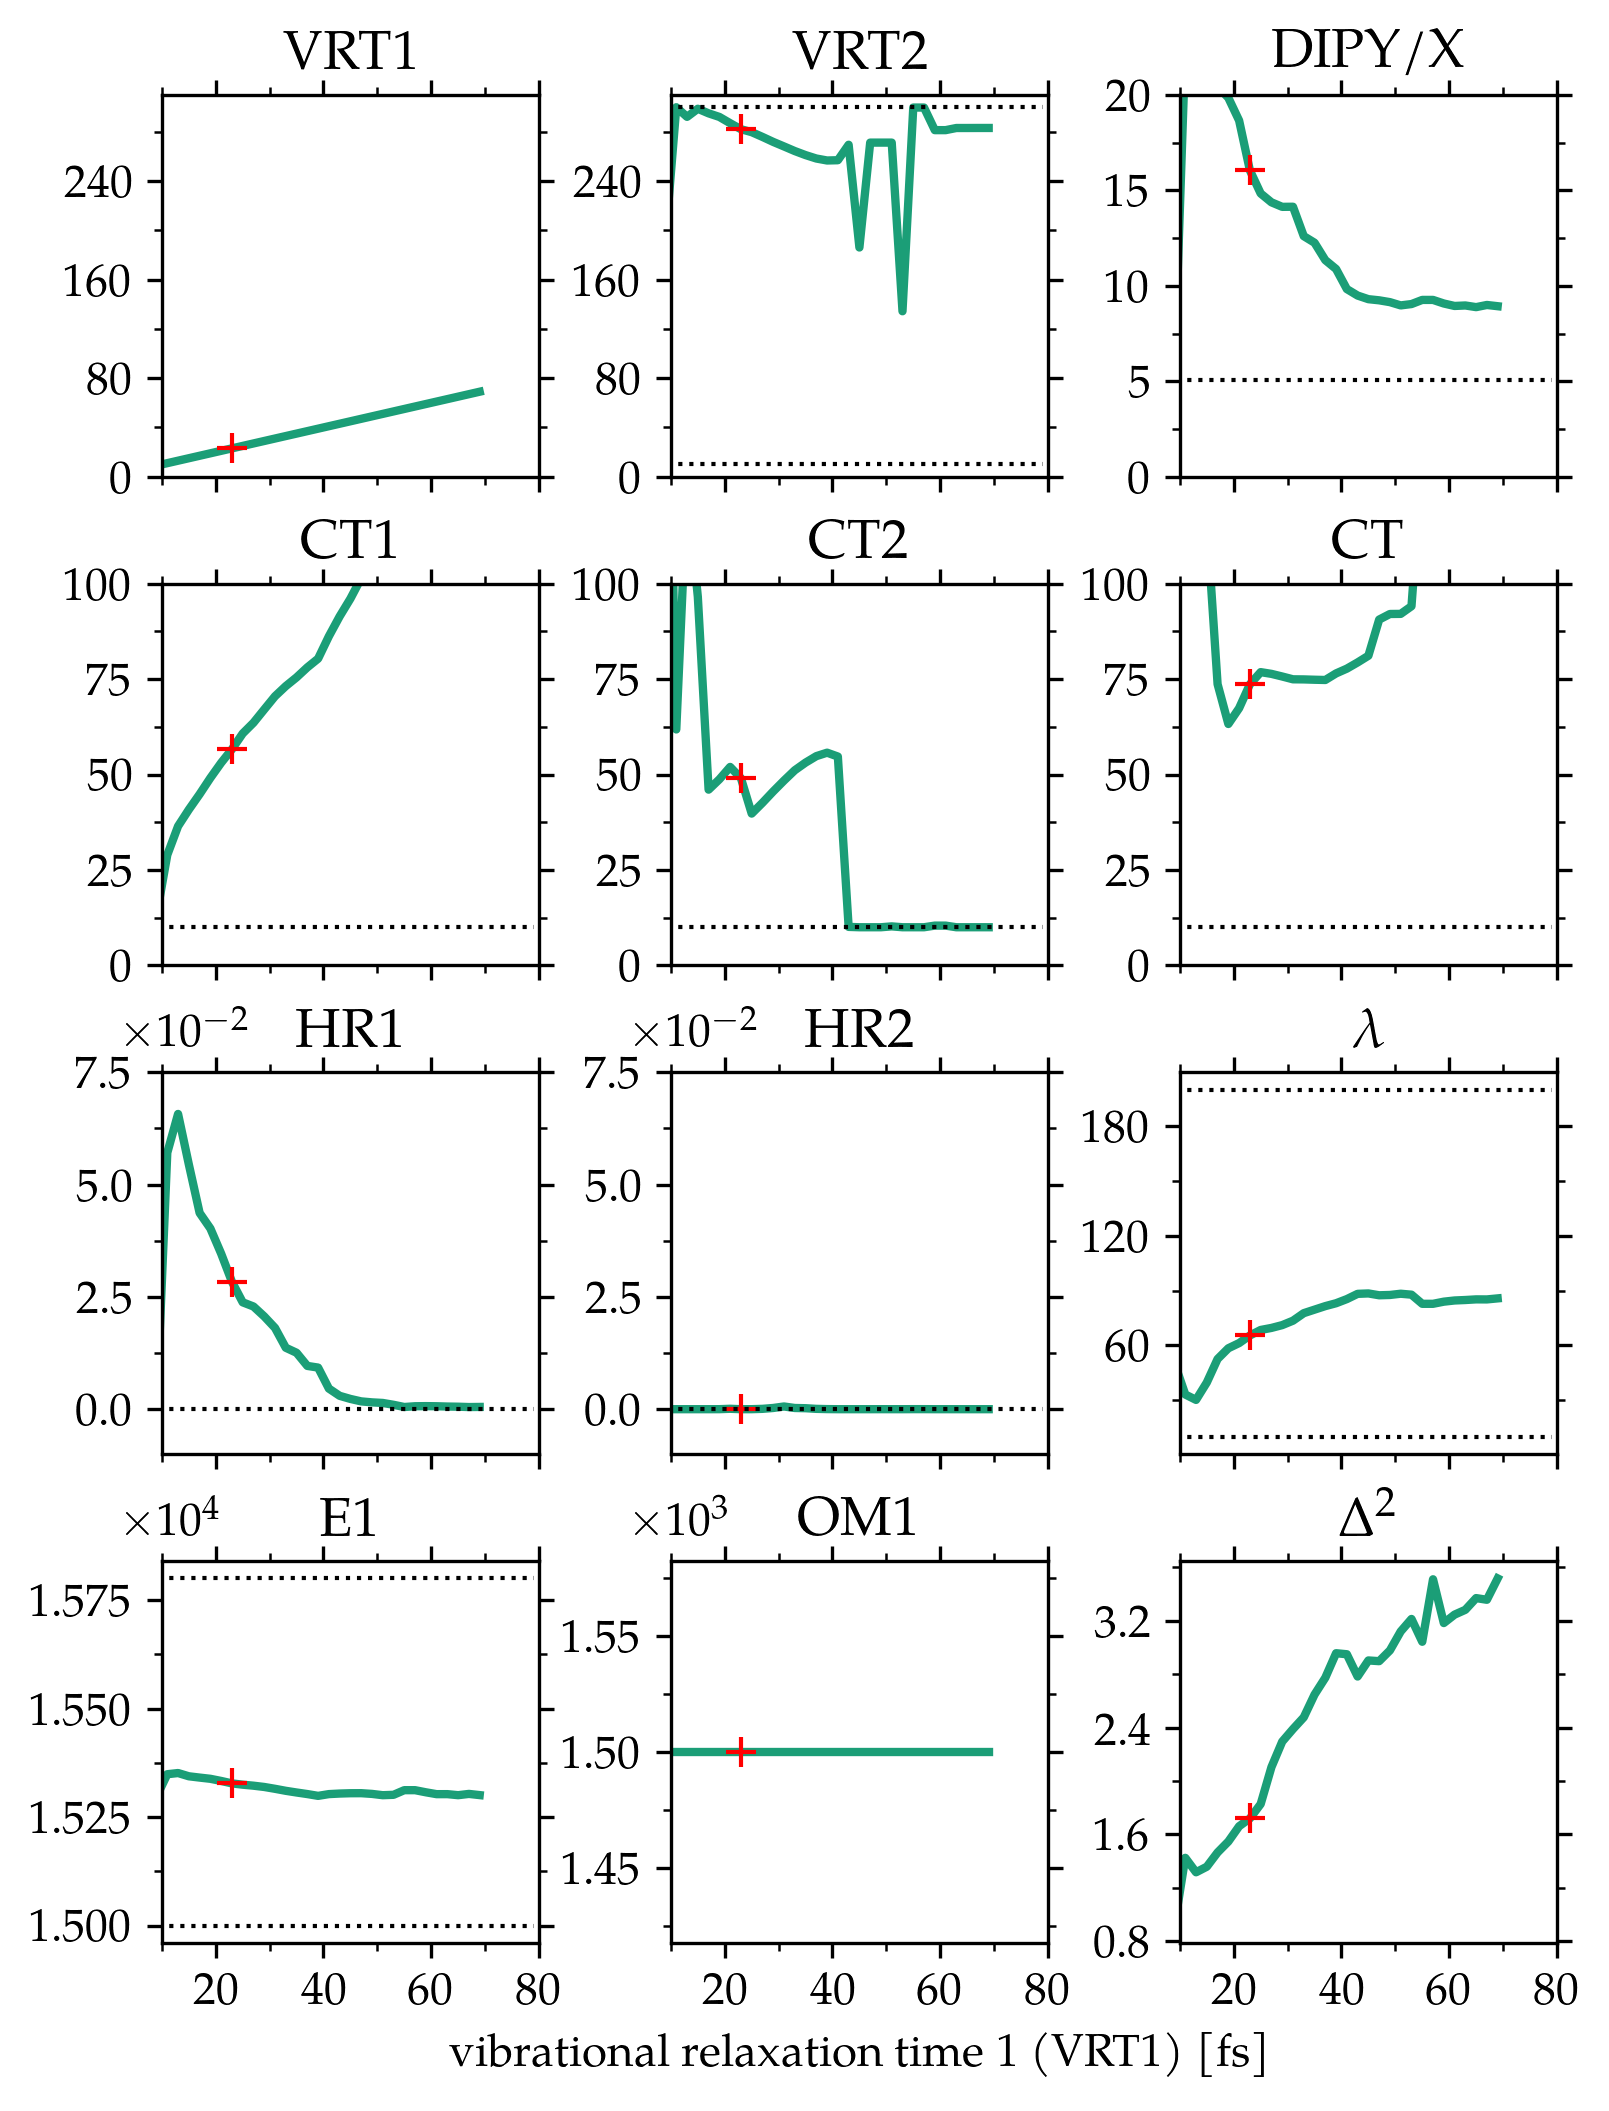

In [10]:
from matplotlib import cm
from spectre.matplotlib_latex import plt_latex, format_ticks

plt_latex()
clm = cm.get_cmap('viridis', len(files))

fig, grid = plt.subplots(4, 3, figsize=(6,8), dpi=300, sharex=True, facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace=0.28, wspace=0.35)

labels = list()

tt11 = list()
tt12 = list()
dipyx = list()
ct11 = list()
ct12 = list()
ct = list()
lamb = list()
hr11 = list()
hr12 = list()
e1 = list()
de = list()
om1 = list()
alpha = list()

for i, f in enumerate(sfiles[:]):
    filepath = os.path.join(path, f)
    optpars = spectre.utils.loadjson(filepath)
    datapath = filepath.replace('.json', '.npy')
    
    if os.path.isfile(datapath):
        data = np.load(datapath)
    else:
        syst, ta = spectre.full.init_system(optpars)
        spec = abss.calculate_abs_spectrum(syst, ta, optpars)
        spec.normalize()
        
        with qr.energy_units('1/cm'):
            data = np.vstack([spec.axis.data, spec.data])
            np.save(datapath, data)

    lab = f.split('.')[0].split('_')[2]
    labels.append(float(lab))

    tt11.append(optpars['scaled_OB_CF_vib_11']['target_time'])
    tt12.append(optpars['scaled_OB_CF_vib_12']['target_time'])
    dipyx.append(4.5**2 / optpars['dipx'][0]**2)
    ct11.append(optpars['scaled_OB_CF_vib_11']['cortime'])
    ct12.append(optpars['scaled_OB_CF_vib_12']['cortime'])
    ct.append(optpars['spectral_density_el']['cortime'])
    lamb.append(optpars['spectral_density_el']['reorg'])
    hr11.append(optpars['hr1'][0])
    hr12.append(optpars['hr1'][1])
    e1.append(optpars['energies'][1])
    de.append(optpars['energies'][2] - optpars['energies'][1])
    om1.append(optpars['omega'][0])
    alpha.append(optpars['dia_alpha1'])

ii = [i for i,x in enumerate(labels) if x == 23][0]

### Line & marker parameters
pars = dict(linewidth=2, )
mpars = dict(marker='+', c='r', markersize=7)
lpars = dict(linewidth=1, linestyle='dotted', c='k')


## TT11
grid[0,0].plot(labels, tt11, **pars)
grid[0,0].plot(labels[ii], tt11[ii], **mpars)
grid[0,0].set_title('VRT1')

## TT12
grid[0,1].plot(labels, tt12, **pars)
grid[0,1].plot(labels[ii], tt12[ii], **mpars)
grid[0,1].set_title('VRT2')
draw_line(grid[0,1], labels, 10, 300, **lpars)
          
## DIP Y/X
grid[0,2].plot(labels, dipyx, **pars)
grid[0,2].plot(labels[ii], dipyx[ii], **mpars)
grid[0,2].set_title('DIPY/X')
draw_line(grid[0,2], labels, 4.5**2 / 0.2**2, 4.5**2 / 2**2, **lpars)

## CT11
grid[1,0].plot(labels, ct11, **pars)
grid[1,0].plot(labels[ii], ct11[ii], **mpars)
grid[1,0].set_title('CT1')
draw_line(grid[1,0], labels, 10, 200, **lpars)

## CT12
grid[1,1].plot(labels, ct12, **pars)
grid[1,1].plot(labels[ii], ct12[ii], **mpars)
grid[1,1].set_title('CT2')
draw_line(grid[1,1], labels, 10, 200, **lpars)

## CT
grid[1,2].plot(labels, ct, **pars)
grid[1,2].plot(labels[ii], ct[ii], **mpars)
grid[1,2].set_title('CT')
draw_line(grid[1,2], labels, 10, 200, **lpars)

## HR11
grid[2,0].plot(labels, hr11, **pars)
grid[2,0].plot(labels[ii], hr11[ii], **mpars)
grid[2,0].set_title('HR1')
draw_line(grid[2,0], labels, 0.00001, 0.4, **lpars)

## HR12
grid[2,1].plot(labels, hr12, **pars)
grid[2,1].plot(labels[ii], hr12[ii], **mpars)
grid[2,1].set_title('HR2')
draw_line(grid[2,1], labels, 0.00001, 0.4, **lpars)

## lambda
grid[2,2].plot(labels, lamb, **pars)
grid[2,2].plot(labels[ii], lamb[ii], **mpars)
grid[2,2].set_title(r'$\lambda$')
draw_line(grid[2,2], labels, 10, 200, **lpars)

## e1
grid[3,0].plot(labels, e1, **pars)
grid[3,0].plot(labels[ii], e1[ii], **mpars)
grid[3,0].set_title('E1')
draw_line(grid[3,0], labels, 15000, 15800, **lpars)

## omega
grid[3,1].plot(labels, om1, **pars)
grid[3,1].plot(labels[ii], om1[ii], **mpars)
grid[3,1].set_title('OM1')
#draw_line(grid[3,1], labels, 0.00001, 0.4, **lpars)

# ## alpha
# grid[3,2].plot(labels, alpha, **pars)
# grid[3,2].plot(labels[ii], alpha[ii], **mpars)
# grid[3,2].set_title(r'$\alpha$')
# #draw_line(grid[3,2], labels, 0.00001, 0.4, **lpars)

## alpha
delta = (zax**2).sum(axis=1)
grid[3,2].plot(labels, delta, **pars)
grid[3,2].plot(labels[ii], delta[ii], **mpars)
grid[3,2].set_title(r'$\Delta^2$')
#draw_line(grid[3,2], labels, 0.00001, 0.4, **lpars)
    


grid[0,0].set_ylim(0,310)
grid[0,1].sharey(grid[0,0])
# grid[0,1].set_ylim(0,250)

grid[1,0].set_ylim(0,100)
grid[1,1].sharey(grid[1,0])
grid[1,2].sharey(grid[1,0])
# grid[1,1].set_ylim(0,100)
# grid[1,2].set_ylim(0,100)

grid[2,0].set_ylim(-0.01, 0.075)
grid[2,1].sharey(grid[2,0])
# grid[2,1].set_ylim(-0.01, 0.075)

grid[0,0].set_xlim(10, 80)

grid[0,2].set_ylim(0,20)

#plt.xlim(14000, 20000)
#plt.ylim(-0.1, 1.1)
#plt.legend(frameon=False)

#sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(labels[0], labels[-1]))
#cbar = plt.colorbar(sm, orientation='horizontal')
#cbar.set_ticklabels(labs)

### TICKS
from matplotlib.ticker import MultipleLocator, AutoMinorLocator, MaxNLocator

for g in grid[:].flatten():
    pars = dict(labelbottom=False, labeltop=False, labelleft=True, labelright=False,
                bottom=True,           top=True,      left=True,      right=True,)
    #minor_pars = dict(bottom=True,           top=True,      left=True,      right=True)
    g.tick_params(which='both', **pars)
    #g.minor_tick_params(**minor_pars)
    
    g.xaxis.set_major_locator(MultipleLocator(20))
    g.xaxis.set_major_formatter('{x:.0f}')
    g.xaxis.set_minor_locator(MultipleLocator(10))
    g.yaxis.set_major_locator(MaxNLocator(nbins=4))
    g.yaxis.set_minor_locator(AutoMinorLocator(2))
    g.ticklabel_format(style='sci', axis='y', scilimits=(-1,3), useOffset=True)

    g.get_yaxis().set_offset_position("left")
    g.get_yaxis().OFFSETTEXTPAD = 7
    #g.get_yaxis().get_offset_text().set_position((-0.032,0))
    g.get_yaxis().get_offset_text().set_position((-0.097,0))

for g in grid[-1].flatten():
    pars = dict(labelbottom=True, labeltop=False, labelleft=True, labelright=False)
    g.tick_params(which='both', **pars)

# plt.locator_params(axis='x', nbins=4)
# plt.locator_params(axis='y', nbins=4)
#fig.tight_layout()

grid[3,1].set_xlabel('vibrational relaxation time 1 (VRT1) [fs]')

# (2.) Finer step ... (s1)

In [12]:
#path = 'C:/Users/micha/Documents/Studium/MScThesis/data-meta/E-scanopt-pyr06-1mode/results_E-pyr06-1mode-P-177_scanopt_01_2023-07-07_17-36-22'
path = 'C:/Users/micha/Documents/Studium/MScThesis/data-meta/E-scanopt-pyr06-1mode/results_E-pyr06-1mode-s1-P-177_scanopt_01_2023-07-10_10-25-54'

In [13]:
files = [file for file in os.listdir(path) if file.endswith('.json') and file.startswith('opt')]
sfiles = sorted(files, key=lambda s: float(s.split('.')[0].split('_')[2]))

C:\Users\micha\AppData\Local\Temp\ipykernel_30028\814600582.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  clm = cm.get_cmap('viridis', len(files))


Reorg: 2113.64446007
Reorg: 28.1819261342
System init: 5.55s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    8.9s finished


Tensor calculation: 1.17s
Spectrum calculation (CPU): 9.11s
Reorg: 1690.91556805
Reorg: 28.1819261342
System init: 4.97s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.1s finished


Tensor calculation: 1.13s
Spectrum calculation (CPU): 4.31s
Reorg: 1409.09630671
Reorg: 28.1819261342
System init: 4.97s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.3s finished


Tensor calculation: 1.13s
Spectrum calculation (CPU): 4.50s
Reorg: 1207.79683432
Reorg: 449.38951102
System init: 5.07s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.1s finished


Tensor calculation: 1.13s
Spectrum calculation (CPU): 4.36s
Reorg: 1109.34009864
Reorg: 626.30925346
System init: 5.07s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.0s finished


Tensor calculation: 1.15s
Spectrum calculation (CPU): 4.24s
Reorg: 1798.2392512
Reorg: 28.2325638244
System init: 5.02s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.6s finished


Tensor calculation: 1.15s
Spectrum calculation (CPU): 4.81s
Reorg: 2050.61729593
Reorg: 155.669786509
System init: 5.06s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.5s finished


Tensor calculation: 1.11s
Spectrum calculation (CPU): 4.78s
Reorg: 2084.42475164
Reorg: 281.899967259
System init: 4.94s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.6s finished


Tensor calculation: 1.12s
Spectrum calculation (CPU): 4.78s
Reorg: 2072.1261983
Reorg: 318.162391761
System init: 5.18s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.5s finished


Tensor calculation: 1.14s
Spectrum calculation (CPU): 4.75s
Reorg: 2138.74778938
Reorg: 385.228207991
System init: 5.02s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.7s finished


Tensor calculation: 1.13s
Spectrum calculation (CPU): 4.86s
Reorg: 2099.72348204
Reorg: 421.543165148
System init: 5.06s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.5s finished


Tensor calculation: 1.13s
Spectrum calculation (CPU): 4.70s
Reorg: 2096.66675962
Reorg: 187.371226418
System init: 5.04s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.6s finished


Tensor calculation: 1.12s
Spectrum calculation (CPU): 4.86s
Reorg: 2133.36920084
Reorg: 199.33382415
System init: 5.07s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.5s finished


Tensor calculation: 1.15s
Spectrum calculation (CPU): 4.72s
Reorg: 2013.07601158
Reorg: 198.87489196
System init: 4.96s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.7s finished


Tensor calculation: 1.13s
Spectrum calculation (CPU): 4.88s
Reorg: 2047.21066708
Reorg: 125.335287575
System init: 4.97s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.5s finished


Tensor calculation: 1.13s
Spectrum calculation (CPU): 4.74s
Reorg: 1951.54574209
Reorg: 126.00864854
System init: 4.94s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.6s finished


Tensor calculation: 1.13s
Spectrum calculation (CPU): 4.77s
Reorg: 1930.58334869
Reorg: 120.823906842
System init: 5.01s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.6s finished


Tensor calculation: 1.19s
Spectrum calculation (CPU): 4.80s
Reorg: 1892.36281279
Reorg: 126.128561191
System init: 5.01s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.5s finished


Tensor calculation: 1.13s
Spectrum calculation (CPU): 4.77s
Reorg: 1902.88240043
Reorg: 68.876468809
System init: 4.97s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.4s finished


Tensor calculation: 1.15s
Spectrum calculation (CPU): 4.58s
Reorg: 1882.4797354
Reorg: 67.4749955474
System init: 5.00s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.2s finished


Tensor calculation: 1.13s
Spectrum calculation (CPU): 4.40s
Reorg: 1870.05049217
Reorg: 28.2206478759
System init: 5.01s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.6s finished


Tensor calculation: 1.14s
Spectrum calculation (CPU): 4.81s
Reorg: 1849.93689996
Reorg: 31.5778893989
System init: 4.98s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.5s finished


Tensor calculation: 1.11s
Spectrum calculation (CPU): 4.75s
Reorg: 1832.3778102
Reorg: 28.18211581
System init: 5.02s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.5s finished


Tensor calculation: 1.14s
Spectrum calculation (CPU): 4.72s
Reorg: 1816.38838271
Reorg: 28.3466664683
System init: 5.01s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.4s finished


Tensor calculation: 1.14s
Spectrum calculation (CPU): 4.56s
Reorg: 1789.15526957
Reorg: 33.6235991153
System init: 5.07s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.3s finished


Tensor calculation: 1.15s
Spectrum calculation (CPU): 4.53s
Reorg: 1761.61296407
Reorg: 72.3065534726
System init: 5.03s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.5s finished


Tensor calculation: 1.15s
Spectrum calculation (CPU): 4.71s
Reorg: 1739.2909167
Reorg: 30.709651499
System init: 5.07s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.7s finished


Tensor calculation: 1.13s
Spectrum calculation (CPU): 4.89s
Reorg: 1768.76877988
Reorg: 28.2306075565
System init: 4.99s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.3s finished


Tensor calculation: 1.10s
Spectrum calculation (CPU): 4.58s
Reorg: 1742.67884559
Reorg: 43.307042983
System init: 4.97s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.4s finished


Tensor calculation: 1.15s
Spectrum calculation (CPU): 4.58s
Reorg: 1723.3888336
Reorg: 93.9282427961
System init: 5.01s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.1s finished


Tensor calculation: 1.12s
Spectrum calculation (CPU): 4.35s
Reorg: 1721.8594559
Reorg: 43.4103312904
System init: 5.05s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.2s finished


Tensor calculation: 1.15s
Spectrum calculation (CPU): 4.42s
Reorg: 1695.0689897
Reorg: 28.4452584508
System init: 4.95s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.0s finished


Tensor calculation: 1.14s
Spectrum calculation (CPU): 4.24s
Reorg: 1693.81089377
Reorg: 28.2214837106
System init: 4.98s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.1s finished


Tensor calculation: 1.11s
Spectrum calculation (CPU): 4.28s
Reorg: 1677.52796491
Reorg: 31.3308532459
System init: 4.96s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.2s finished


Tensor calculation: 1.12s
Spectrum calculation (CPU): 4.38s
Reorg: 1692.35383614
Reorg: 30.9065599059
System init: 5.05s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.4s finished


Tensor calculation: 1.12s
Spectrum calculation (CPU): 4.58s
Reorg: 1679.20310978
Reorg: 30.8779642445
System init: 5.04s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.1s finished


Tensor calculation: 1.12s
Spectrum calculation (CPU): 4.35s
Reorg: 1671.33513762
Reorg: 30.8719290609
System init: 4.96s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.3s finished


Tensor calculation: 1.15s
Spectrum calculation (CPU): 4.53s
Reorg: 1658.34725616
Reorg: 30.8696514574
System init: 5.04s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.2s finished


Tensor calculation: 1.12s
Spectrum calculation (CPU): 4.42s
Reorg: 1668.62130369
Reorg: 28.8199929343
System init: 5.00s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.2s finished


Tensor calculation: 1.14s
Spectrum calculation (CPU): 4.43s
Reorg: 1651.16343912
Reorg: 28.4542020797
System init: 4.97s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.6s finished


Tensor calculation: 1.36s
Spectrum calculation (CPU): 4.78s
Reorg: 1668.03329178
Reorg: 28.4488133971
System init: 6.77s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.4s finished


Tensor calculation: 1.26s
Spectrum calculation (CPU): 4.56s
Reorg: 1683.1587656
Reorg: 28.400856822
System init: 5.77s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    5.1s finished


Tensor calculation: 1.75s
Spectrum calculation (CPU): 5.30s
Reorg: 1754.9993234
Reorg: 28.2667840575
System init: 5.82s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.8s finished


Tensor calculation: 1.27s
Spectrum calculation (CPU): 4.99s
Reorg: 1728.72309797
Reorg: 28.2667409043
System init: 5.87s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.5s finished


Tensor calculation: 1.29s
Spectrum calculation (CPU): 4.69s
Reorg: 1742.00056691
Reorg: 28.2379040421
System init: 6.11s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.5s finished


Tensor calculation: 1.27s
Spectrum calculation (CPU): 4.68s
Reorg: 1712.13733512
Reorg: 28.2378952312
System init: 5.63s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.9s finished


Tensor calculation: 1.44s
Spectrum calculation (CPU): 5.08s
Reorg: 1720.04763864
Reorg: 28.2375989823
System init: 5.50s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.7s finished


Tensor calculation: 1.19s
Spectrum calculation (CPU): 4.92s
Reorg: 1730.21670898
Reorg: 28.2369616969
System init: 6.02s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.5s finished


Tensor calculation: 1.38s
Spectrum calculation (CPU): 4.76s
Reorg: 1705.49361738
Reorg: 28.2369426857
System init: 6.31s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.6s finished


Tensor calculation: 1.22s
Spectrum calculation (CPU): 4.84s
Reorg: 1713.6932969
Reorg: 28.2365620325
System init: 5.47s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    5.0s finished


Tensor calculation: 1.42s
Spectrum calculation (CPU): 5.19s
Reorg: 1694.38030568
Reorg: 28.2369236602
System init: 5.88s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.4s finished


Tensor calculation: 1.30s
Spectrum calculation (CPU): 4.57s
Reorg: 1681.23189524
Reorg: 28.2368536727
System init: 5.93s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.4s finished


Tensor calculation: 1.40s
Spectrum calculation (CPU): 4.64s
Reorg: 1695.22023816
Reorg: 28.2349518311
System init: 6.23s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.6s finished


Tensor calculation: 1.27s
Spectrum calculation (CPU): 4.84s
Reorg: 1676.64671161
Reorg: 28.2349090977
System init: 5.59s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.9s finished


Tensor calculation: 1.30s
Spectrum calculation (CPU): 5.15s
Reorg: 1674.02872806
Reorg: 28.2347392469
System init: 5.50s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.3s finished


Tensor calculation: 1.35s
Spectrum calculation (CPU): 4.52s
Reorg: 1685.13468826
Reorg: 28.2343082102
System init: 6.52s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.5s finished


Tensor calculation: 1.27s
Spectrum calculation (CPU): 4.69s
Reorg: 1685.60944175
Reorg: 28.2340836649
System init: 6.42s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.3s finished


Tensor calculation: 1.22s
Spectrum calculation (CPU): 4.50s
Reorg: 1682.18751722
Reorg: 29.2093158539
System init: 5.65s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.9s finished


Tensor calculation: 1.25s
Spectrum calculation (CPU): 5.14s
Reorg: 1664.13545472
Reorg: 29.2082941366
System init: 6.06s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.5s finished


Tensor calculation: 1.30s
Spectrum calculation (CPU): 4.67s
Reorg: 1668.15359595
Reorg: 29.1810691039
System init: 6.40s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.5s finished


Tensor calculation: 1.26s
Spectrum calculation (CPU): 4.70s
Reorg: 1650.46414762
Reorg: 29.1800746815
System init: 5.96s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.6s finished


Tensor calculation: 1.64s
Spectrum calculation (CPU): 4.84s
Reorg: 1668.95326229
Reorg: 29.1677967019
System init: 5.58s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.9s finished


Tensor calculation: 1.32s
Spectrum calculation (CPU): 5.09s
Reorg: 1654.41345746
Reorg: 29.1659157692
System init: 6.07s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.5s finished


Tensor calculation: 1.37s
Spectrum calculation (CPU): 4.68s
Reorg: 1654.5040178
Reorg: 29.1600015757
System init: 6.51s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.3s finished


Tensor calculation: 1.23s
Spectrum calculation (CPU): 4.53s
Reorg: 1671.08415255
Reorg: 29.1485430781
System init: 6.14s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.5s finished


Tensor calculation: 1.82s
Spectrum calculation (CPU): 4.72s
Reorg: 1646.86554165
Reorg: 29.1485430781
System init: 5.57s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.7s finished
C:\Users\micha\AppData\Local\Temp\ipykernel_30028\814600582.py:32: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, orientation='horizontal')


Tensor calculation: 1.28s
Spectrum calculation (CPU): 4.94s


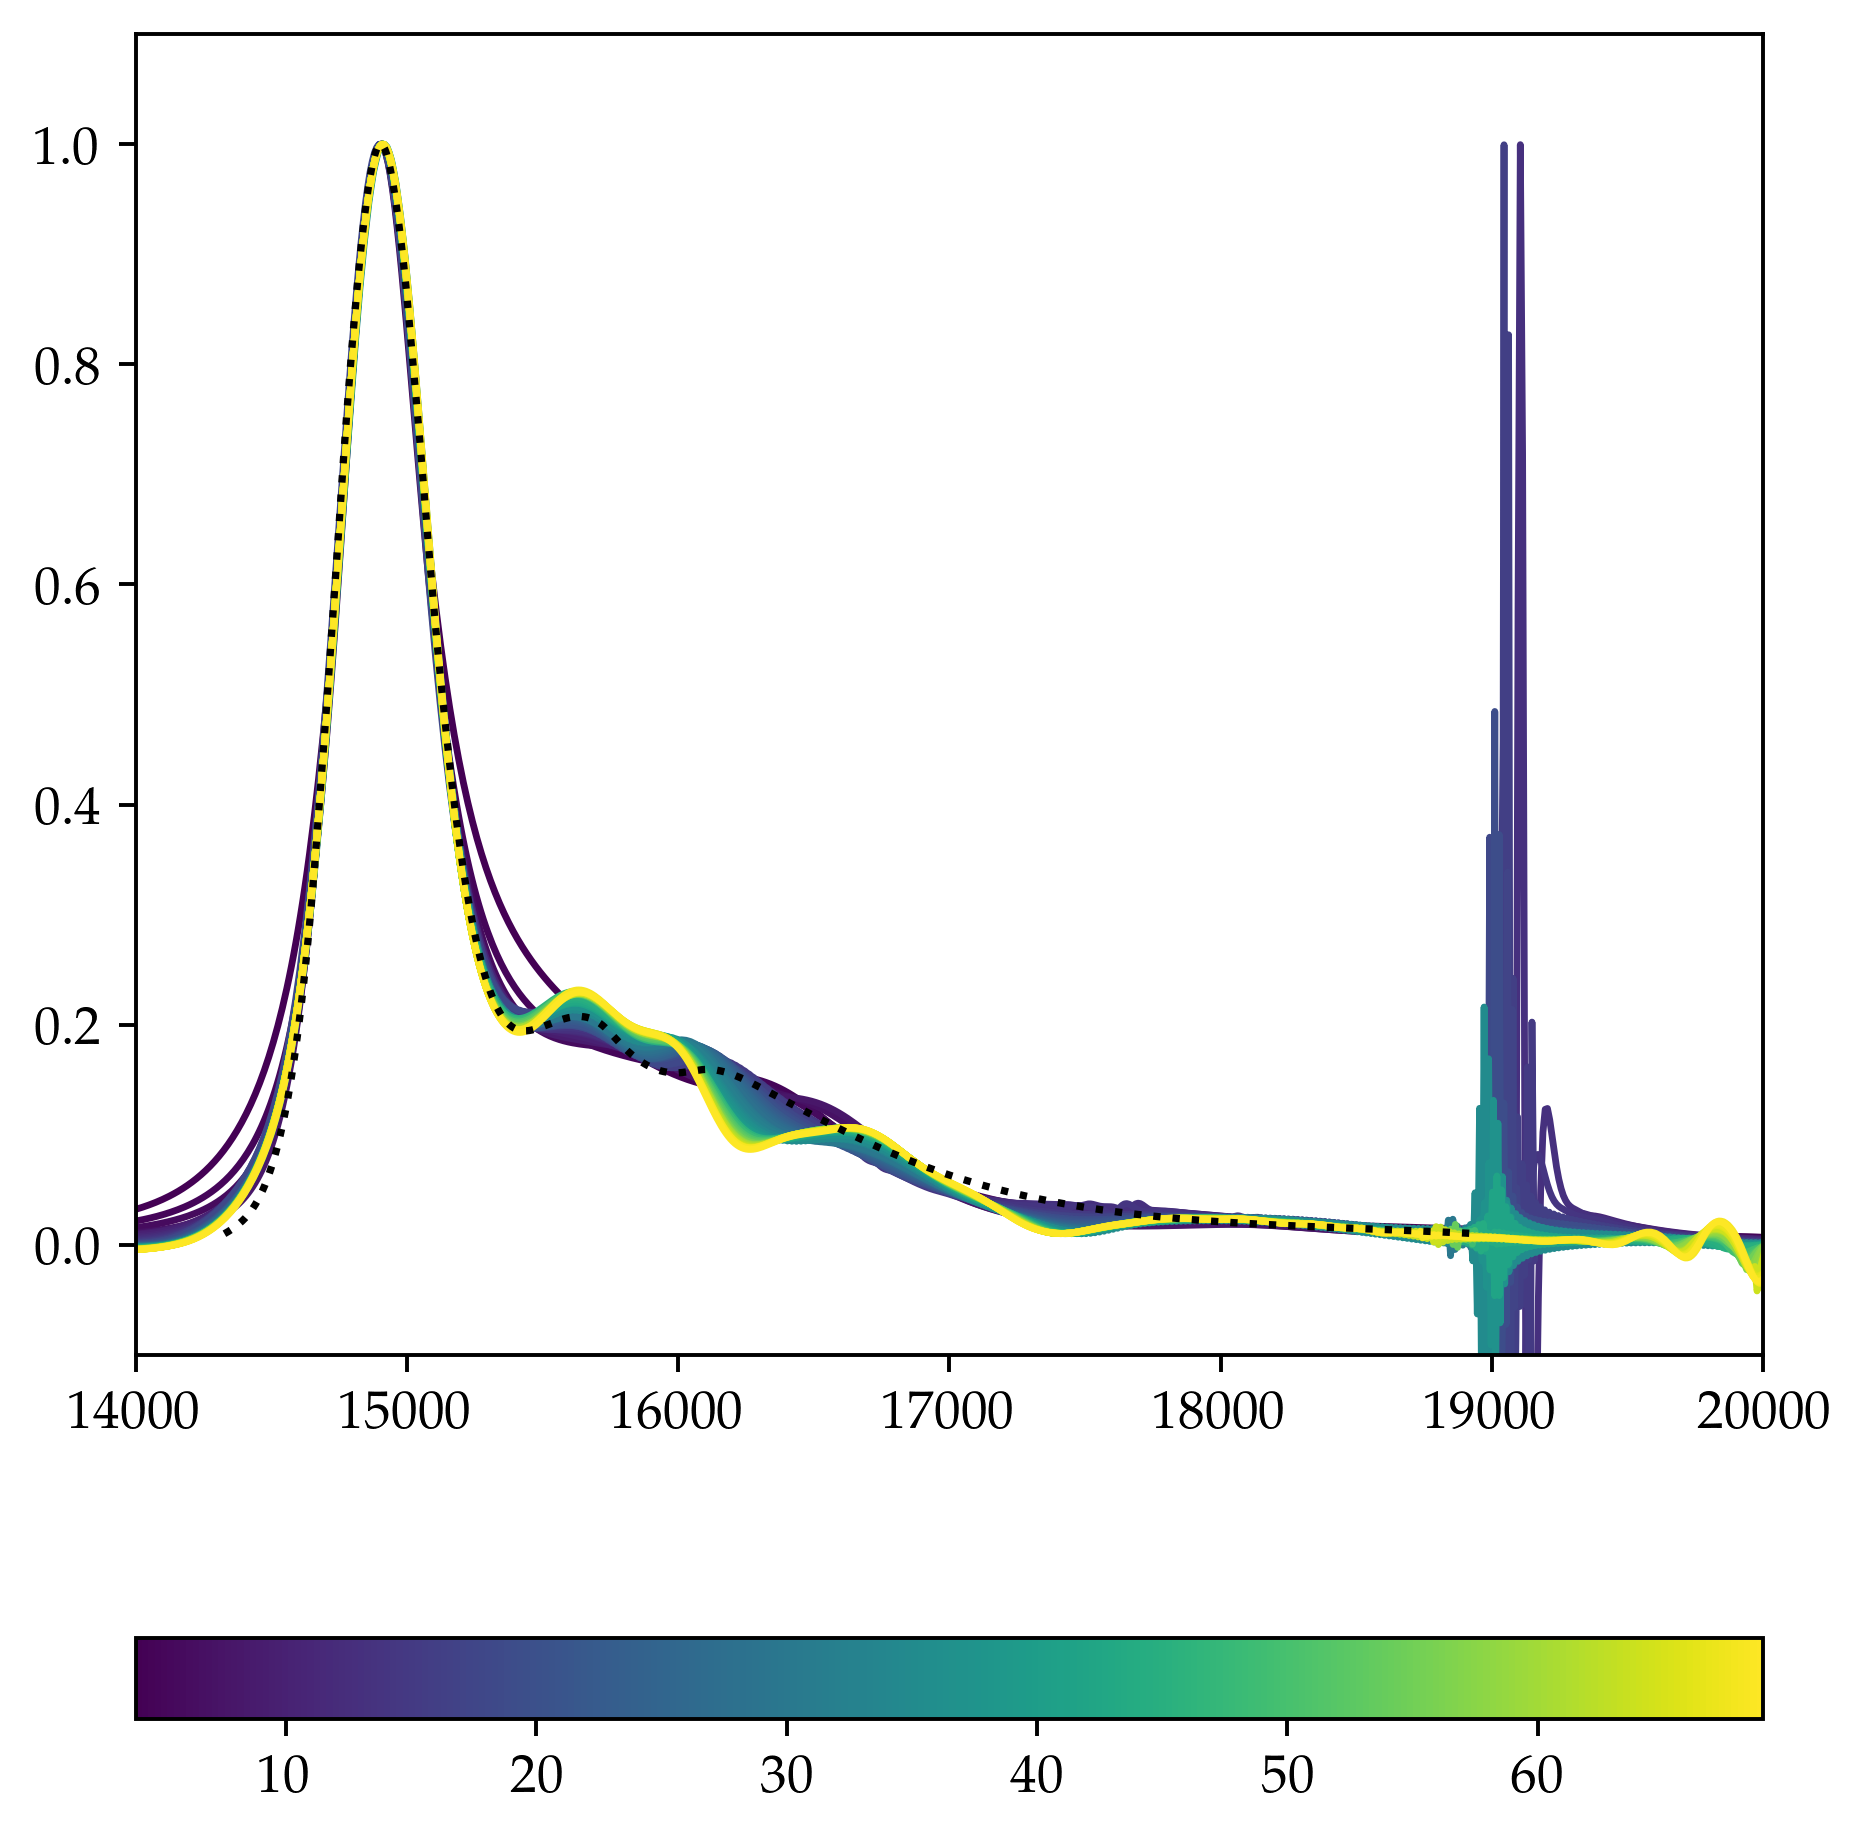

In [14]:
from matplotlib import cm
clm = cm.get_cmap('viridis', len(files))

fig, ax = plt.subplots(figsize=(6,7), dpi= 350)
labels = list()

for i, f in enumerate(sfiles[:]):
    filepath = os.path.join(path, f)
    optpars = spectre.utils.loadjson(filepath)
    datapath = filepath.replace('.json', '.npy')
    
    if os.path.isfile(datapath):
        data = np.load(datapath)
    else:
        syst, ta = spectre.full.init_system(optpars)
        spec = abss.calculate_abs_spectrum(syst, ta, optpars)
        spec.normalize()
        
        with qr.energy_units('1/cm'):
            data = np.vstack([spec.axis.data, spec.data])
            np.save(datapath, data)

    lab = f.split('.')[0].split('_')[2]
    plt.plot(data[0], data[1], label=lab, linewidth=1.4, color=clm(i))
    labels.append(lab)

plt.xlim(14000, 20000)
plt.ylim(-0.1, 1.1)
#plt.legend(frameon=False)

sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(labels[0], labels[-1]))
cbar = plt.colorbar(sm, orientation='horizontal')
#cbar.set_ticklabels(labs)

abss.plot_ref(6, plot_to=ax, color='k', linestyle = 'dotted')

C:\Users\micha\AppData\Local\Temp\ipykernel_30028\515961166.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  clm = cm.get_cmap('viridis', len(files))
C:\Users\micha\AppData\Local\Temp\ipykernel_30028\515961166.py:18: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax0 = plt.subplot(gs[3])
100%|█████████████████████████████████████████████████████████████████████████████████████| 66/66 [00:02<00:00, 32.72it/s]


Text(0, 0.5, 'residuum')

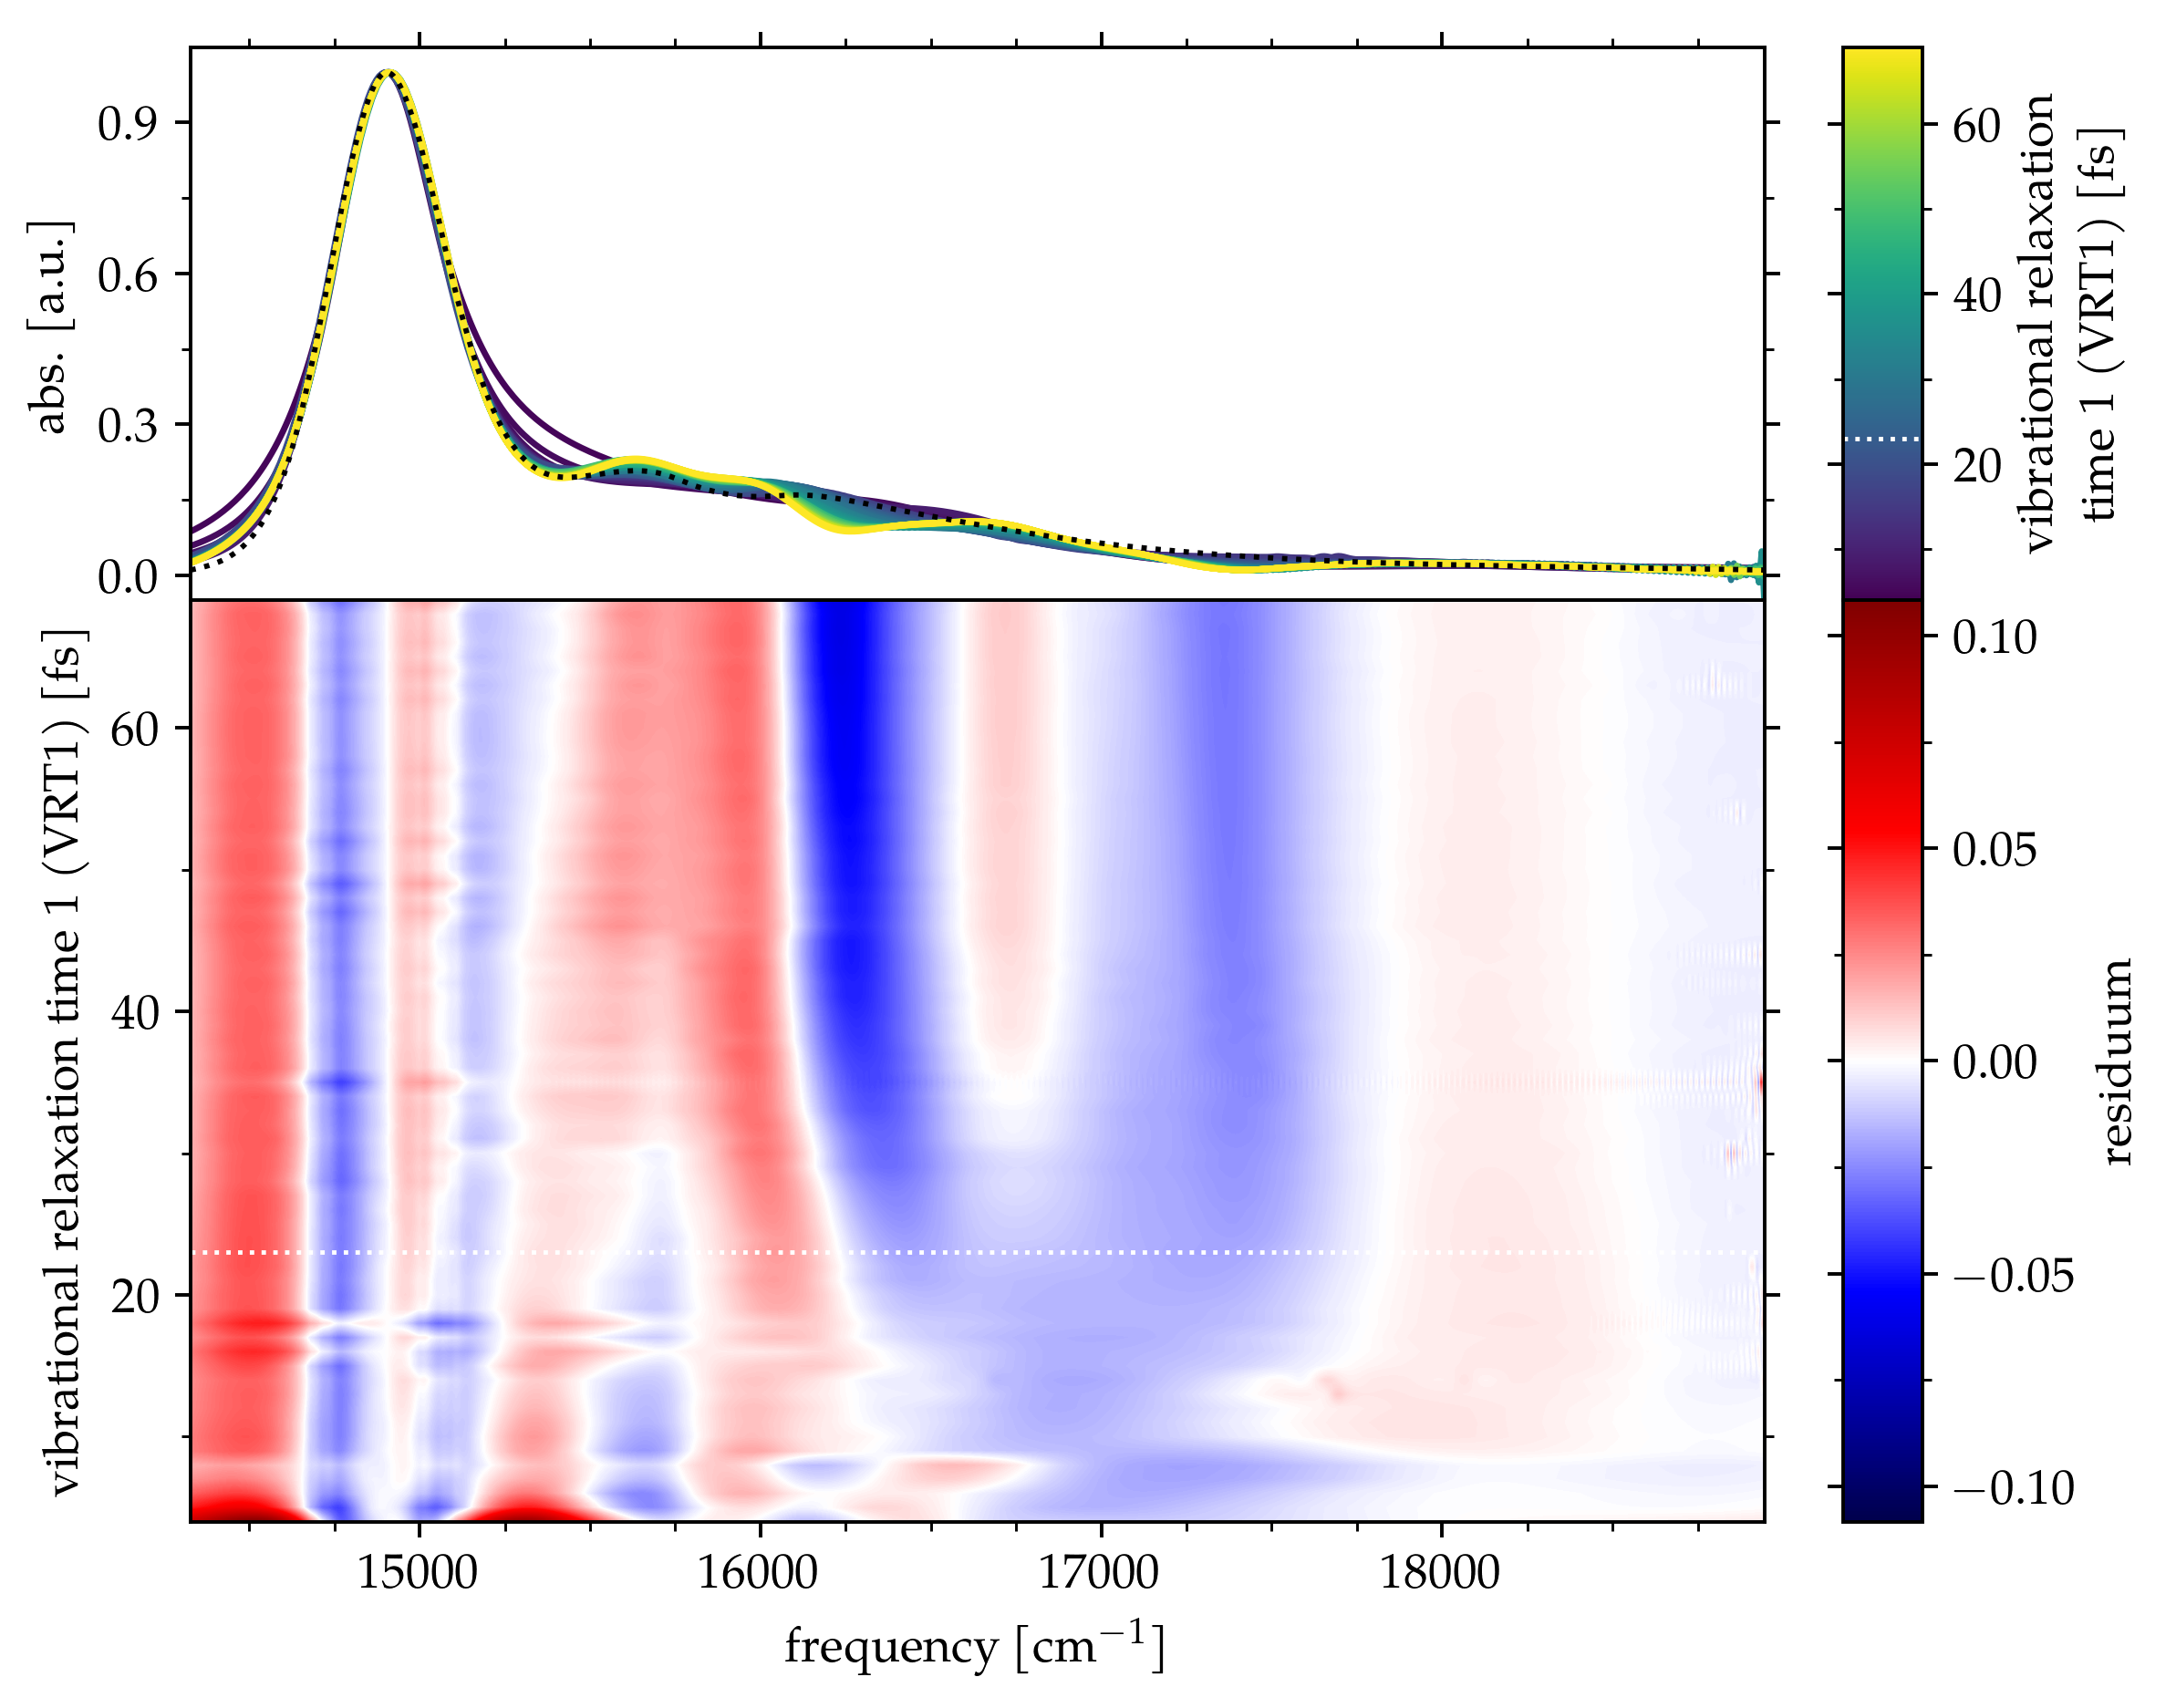

In [15]:
from matplotlib import cm
from scipy.interpolate import UnivariateSpline
from tqdm import tqdm
from matplotlib import gridspec

spline_s=0.0002
spline_k=3
ref_id = 6

clm = cm.get_cmap('viridis', len(files))

refdata = abss.plot_ref(ref_id, return_data='data', plot=False)
refx, refy = refdata

fig, ax = plt.subplots(num=None, figsize=(7,6), dpi=350, facecolor='w', edgecolor='k')
gs = gridspec.GridSpec(nrows=2, ncols=3, width_ratios=(1, 0.05, 0.05), height_ratios=(0.6, 1), figure=fig) 
#ax3 = plt.subplot(gs[3])
ax0 = plt.subplot(gs[3])
ax1 = plt.subplot(gs[0], sharex = ax0)
ax4 = plt.subplot(gs[5])
ax2 = plt.subplot(gs[2])
plt.subplots_adjust(hspace=0, wspace=0)

####################
#   ax1   #  # ax2 #
####################
#   ax0   #  # ax4 #
####################

all_data_filename = 'all_data.npy'
all_data_path = os.path.join(path, all_data_filename)

if os.path.isfile(all_data_path) and True:
    x, y, zdata = np.load(all_data_path)

    for i, z in enumerate(zdata):
        ax1.plot(x[i], z, linewidth=1.4, color=clm(i))
    
    zax = zdata - refy

else:
    labels = list()
    zax = None
    zdata = None
    i = 0

    for f in tqdm(sfiles[:]):
        i += 1
        filepath = os.path.join(path, f)
        optpars = spectre.utils.loadjson(filepath)
        datapath = filepath.replace('.json', '.npy')
        
        if os.path.isfile(datapath):
            data = np.load(datapath)
        else:
            syst, ta = spectre.full.init_system(optpars)
            spec = abss.calculate_abs_spectrum(syst, ta, optpars)
            spec.normalize()
            
            with qr.energy_units('1/cm'):
                data = np.vstack([spec.axis.data, spec.data])
                np.save(datapath, data)
    
        lab = f.split('.')[0].split('_')[2]
        spline = UnivariateSpline(*data, k=spline_k, s=spline_s)
        ydat = spline(refx) - refy
        
        if zax is None:
            zax = ydat
            zdata = spline(refx)
        else:
            zax = np.vstack([zax, ydat])
            zdata = np.vstack([zdata, spline(refx)])
        
        ax1.plot(data[0], data[1], label=lab, linewidth=1.4, color=clm(i))
        labels.append(float(lab))

    yax = np.array(labels)
    xax = refx
    x, y = np.meshgrid(xax, yax)
    np.save(all_data_path, np.array([x, y, zdata]))

maximum = np.abs(zax).max()

cf = ax0.contourf(x, y, zax, 500, cmap="seismic", vmax=maximum, vmin=-maximum)

#CS = ax0.contour(x, y, zax, 5)
#ax0.clabel(CS, inline=True, fontsize=10)

sm = plt.cm.ScalarMappable(cmap='seismic', norm=plt.Normalize(-maximum, maximum))
cbar = plt.colorbar(sm, cax=ax4, orientation='vertical')

sm2 = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(y[0,0], y[-1,0]))
cbar2 = plt.colorbar(sm2, cax=ax2, orientation='vertical')

ax0.plot([x[0,0], x[0,-1]], [23,23], linewidth=1, linestyle='dotted', c='w')
ax2.plot([0, 1], [23,23], linewidth=1, linestyle='dotted', c='w')

abss.plot_ref(ref_id, plot_to=ax1, linestyle='dotted', c='k', linewidth=1.2)

from matplotlib.ticker import MultipleLocator, AutoMinorLocator, MaxNLocator

for g in [ax0, ax1, ax2, ax4]:
    pars = dict(labelbottom=False, labeltop=False, labelleft=True, labelright=False,
                bottom=True,           top=True,      left=True,      right=True,)
    g.tick_params(which='both', **pars)
    
    #g.xaxis.set_major_locator(MultipleLocator(20))
    #g.xaxis.set_major_formatter('{x:.0f}')
    #g.xaxis.set_minor_locator(MultipleLocator(10))
    g.yaxis.set_major_locator(MaxNLocator(nbins=4))
    g.yaxis.set_minor_locator(AutoMinorLocator(2))
    g.xaxis.set_minor_locator(AutoMinorLocator(4))
    #g.ticklabel_format(style='sci', axis='y', scilimits=(-1,3), useOffset=True)

    #g.get_yaxis().set_offset_position("left")
    #g.get_yaxis().OFFSETTEXTPAD = 7
    #g.get_yaxis().get_offset_text().set_position((-0.097,0))

ax4.yaxis.set_major_locator(MaxNLocator(nbins=5))

ax0.tick_params(which='both', labelbottom=True, labelleft=True)
ax1.tick_params(which='both', bottom=False)
ax2.tick_params(which='both', labelleft=False, labelright=True)
ax4.tick_params(which='both', labelleft=False, labelright=True)

ax0.set_xlim(x[0,0], x[0,-1])
ax1.set_ylim(-0.05, 1.05)

ax0.set_xlabel(r'frequency [cm$^{-1}$]')
ax0.set_ylabel(r'vibrational relaxation time 1 (VRT1) [fs]')
ax1.set_ylabel(r'abs. [a.u.]')
ax2.set_ylabel(r'\parbox{40mm}{\centering vibrational relaxation time 1 (VRT1) [fs]}')
ax4.set_ylabel(r'residuum')

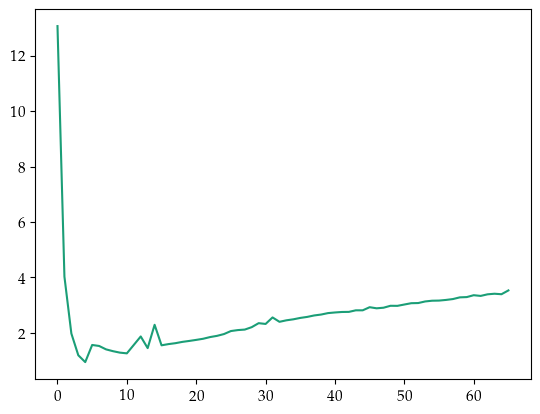

In [16]:
plt.plot((zax**2).sum(axis=1))

In [17]:
def draw_line(plot_to, xaxis, *vals, **pars):
    for val in vals:
        plot_to.plot([xaxis[0]-10, xaxis[-1]+10], [val, val], **pars)

C:\Users\micha\AppData\Local\Temp\ipykernel_30028\391603625.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  clm = cm.get_cmap('viridis', len(files))


Text(0.5, 0, 'vibrational relaxation time 1 (VRT1) [fs]')

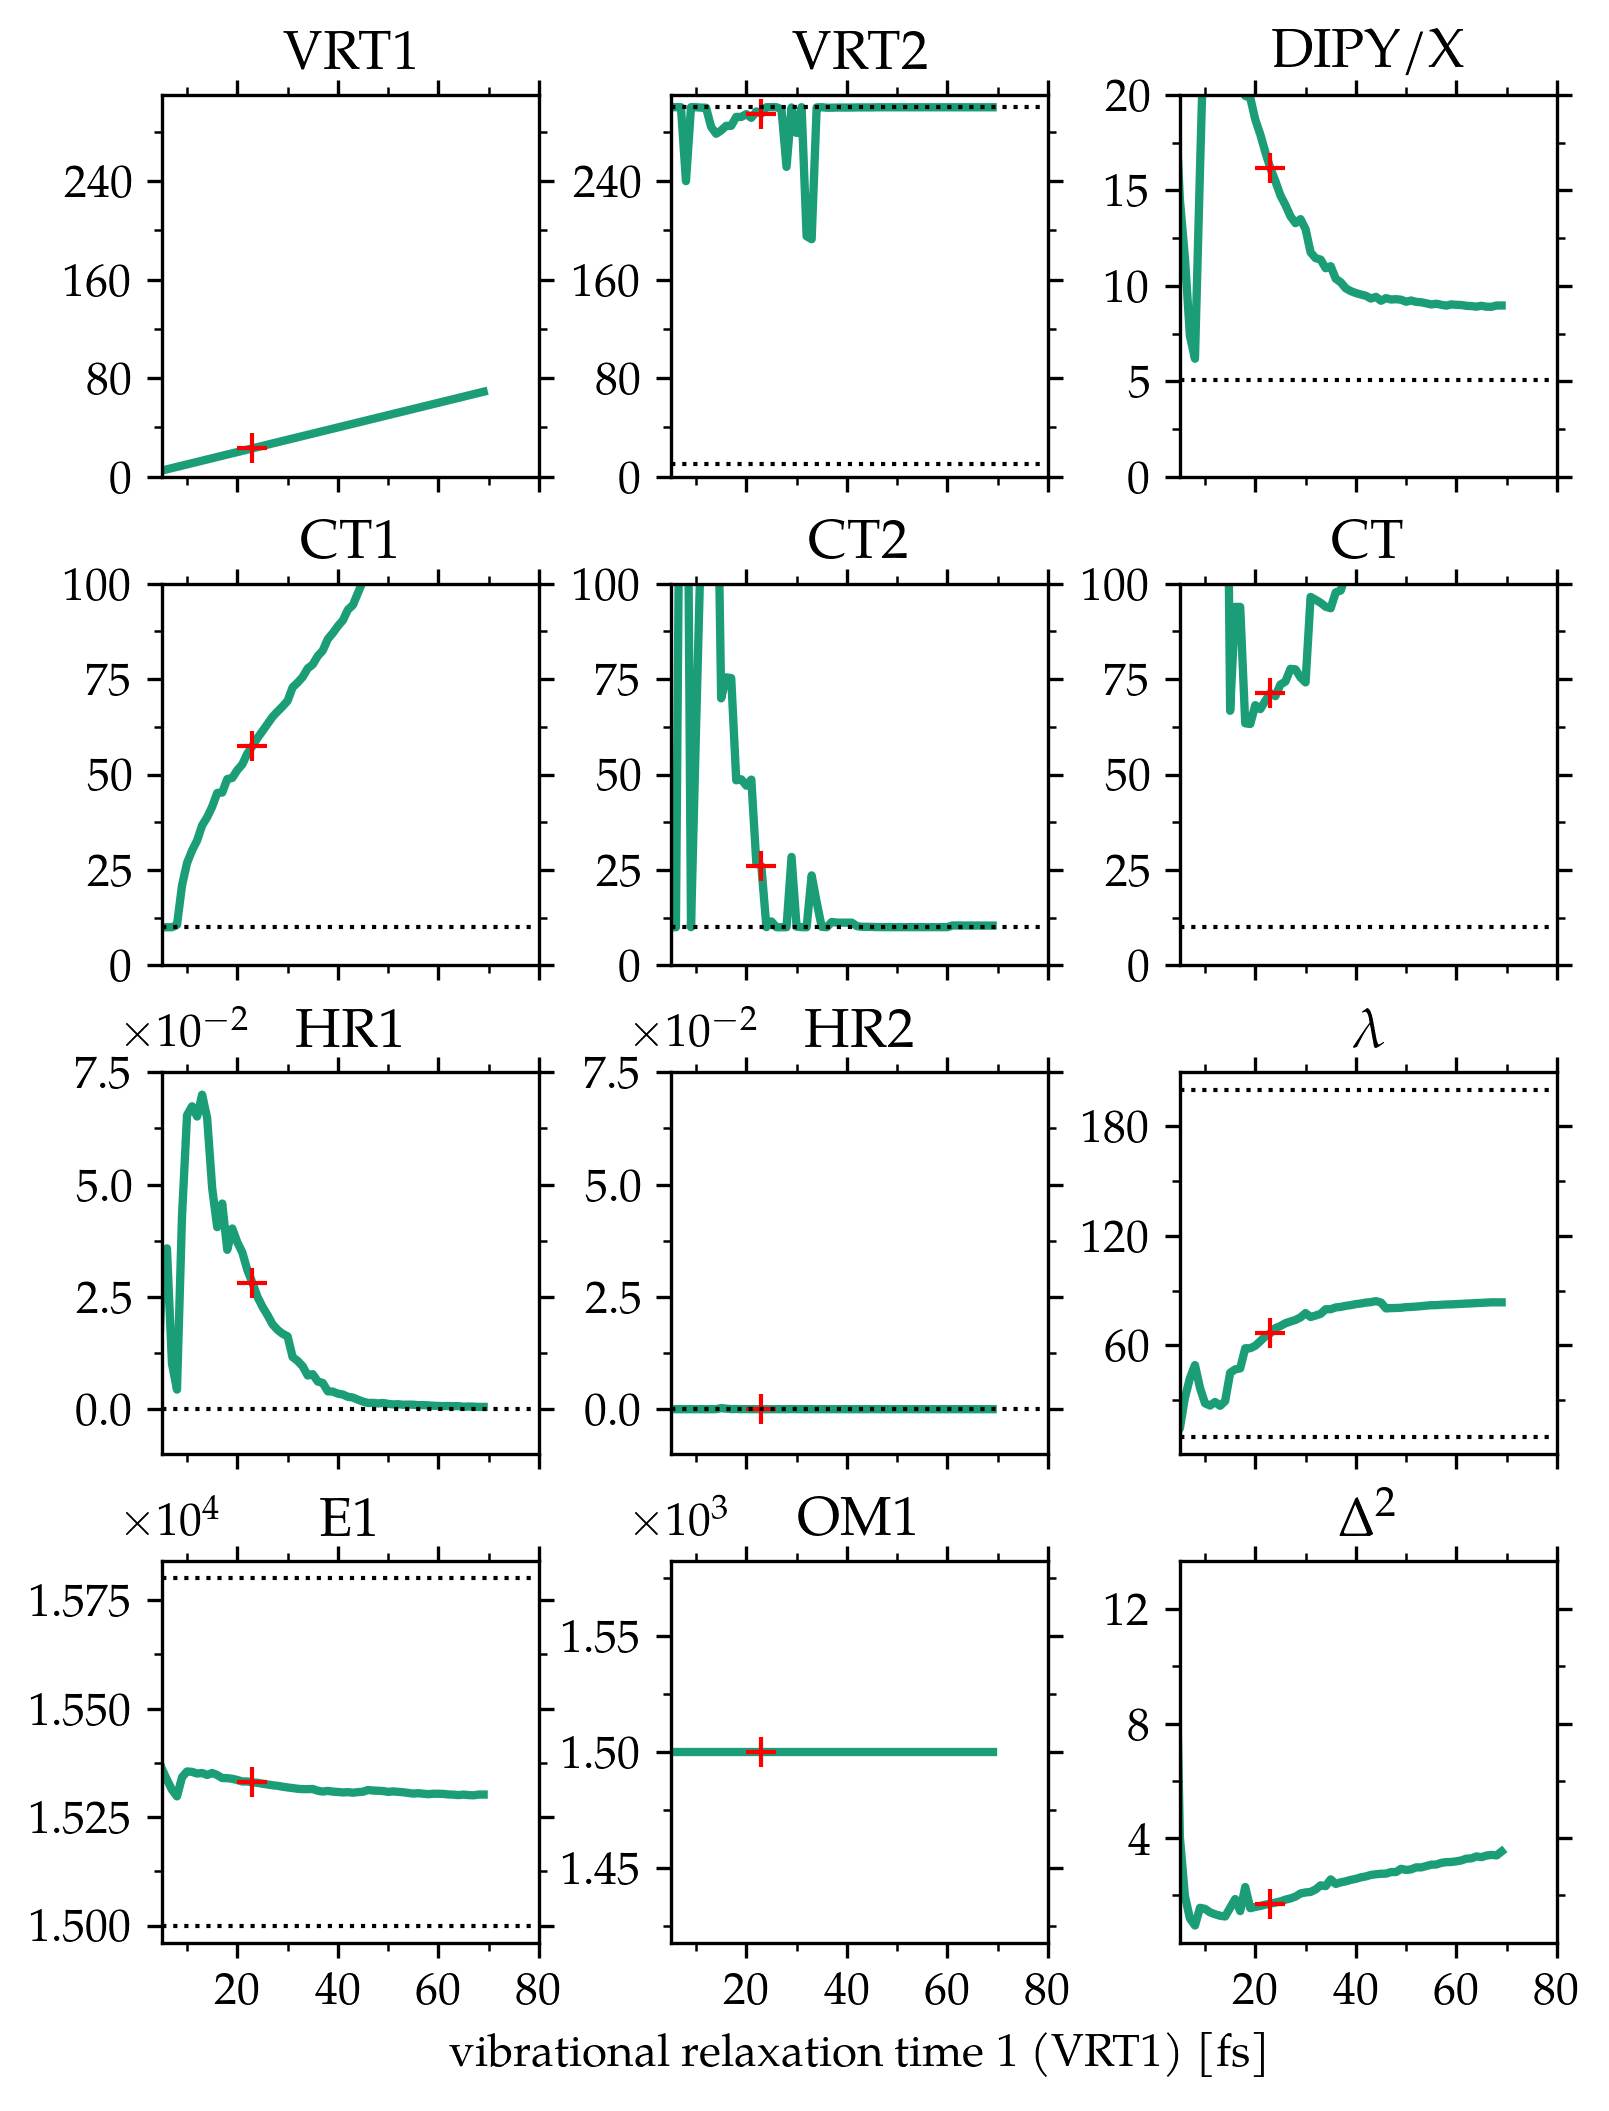

In [19]:
from matplotlib import cm
from spectre.matplotlib_latex import plt_latex, format_ticks

plt_latex()
clm = cm.get_cmap('viridis', len(files))

fig, grid = plt.subplots(4, 3, figsize=(6,8), dpi=300, sharex=True, facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace=0.28, wspace=0.35)

labels = list()

tt11 = list()
tt12 = list()
dipyx = list()
ct11 = list()
ct12 = list()
ct = list()
lamb = list()
hr11 = list()
hr12 = list()
e1 = list()
de = list()
om1 = list()
alpha = list()

for i, f in enumerate(sfiles[:]):
    filepath = os.path.join(path, f)
    optpars = spectre.utils.loadjson(filepath)
    datapath = filepath.replace('.json', '.npy')
    
    if os.path.isfile(datapath):
        data = np.load(datapath)
    else:
        syst, ta = spectre.full.init_system(optpars)
        spec = abss.calculate_abs_spectrum(syst, ta, optpars)
        spec.normalize()
        
        with qr.energy_units('1/cm'):
            data = np.vstack([spec.axis.data, spec.data])
            np.save(datapath, data)

    lab = f.split('.')[0].split('_')[2]
    labels.append(float(lab))

    tt11.append(optpars['scaled_OB_CF_vib_11']['target_time'])
    tt12.append(optpars['scaled_OB_CF_vib_12']['target_time'])
    dipyx.append(4.5**2 / optpars['dipx'][0]**2)
    ct11.append(optpars['scaled_OB_CF_vib_11']['cortime'])
    ct12.append(optpars['scaled_OB_CF_vib_12']['cortime'])
    ct.append(optpars['spectral_density_el']['cortime'])
    lamb.append(optpars['spectral_density_el']['reorg'])
    hr11.append(optpars['hr1'][0])
    hr12.append(optpars['hr1'][1])
    e1.append(optpars['energies'][1])
    de.append(optpars['energies'][2] - optpars['energies'][1])
    om1.append(optpars['omega'][0])
    alpha.append(optpars['dia_alpha1'])

ii = [i for i,x in enumerate(labels) if x == 23][0]

### Line & marker parameters
pars = dict(linewidth=2, )
mpars = dict(marker='+', c='r', markersize=7)
lpars = dict(linewidth=1, linestyle='dotted', c='k')


## TT11
grid[0,0].plot(labels, tt11, **pars)
grid[0,0].plot(labels[ii], tt11[ii], **mpars)
grid[0,0].set_title('VRT1')

## TT12
grid[0,1].plot(labels, tt12, **pars)
grid[0,1].plot(labels[ii], tt12[ii], **mpars)
grid[0,1].set_title('VRT2')
draw_line(grid[0,1], labels, 10, 300, **lpars)
          
## DIP Y/X
grid[0,2].plot(labels, dipyx, **pars)
grid[0,2].plot(labels[ii], dipyx[ii], **mpars)
grid[0,2].set_title('DIPY/X')
draw_line(grid[0,2], labels, 4.5**2 / 0.2**2, 4.5**2 / 2**2, **lpars)

## CT11
grid[1,0].plot(labels, ct11, **pars)
grid[1,0].plot(labels[ii], ct11[ii], **mpars)
grid[1,0].set_title('CT1')
draw_line(grid[1,0], labels, 10, 200, **lpars)

## CT12
grid[1,1].plot(labels, ct12, **pars)
grid[1,1].plot(labels[ii], ct12[ii], **mpars)
grid[1,1].set_title('CT2')
draw_line(grid[1,1], labels, 10, 200, **lpars)

## CT
grid[1,2].plot(labels, ct, **pars)
grid[1,2].plot(labels[ii], ct[ii], **mpars)
grid[1,2].set_title('CT')
draw_line(grid[1,2], labels, 10, 200, **lpars)

## HR11
grid[2,0].plot(labels, hr11, **pars)
grid[2,0].plot(labels[ii], hr11[ii], **mpars)
grid[2,0].set_title('HR1')
draw_line(grid[2,0], labels, 0.00001, 0.4, **lpars)

## HR12
grid[2,1].plot(labels, hr12, **pars)
grid[2,1].plot(labels[ii], hr12[ii], **mpars)
grid[2,1].set_title('HR2')
draw_line(grid[2,1], labels, 0.00001, 0.4, **lpars)

## lambda
grid[2,2].plot(labels, lamb, **pars)
grid[2,2].plot(labels[ii], lamb[ii], **mpars)
grid[2,2].set_title(r'$\lambda$')
draw_line(grid[2,2], labels, 10, 200, **lpars)

## e1
grid[3,0].plot(labels, e1, **pars)
grid[3,0].plot(labels[ii], e1[ii], **mpars)
grid[3,0].set_title('E1')
draw_line(grid[3,0], labels, 15000, 15800, **lpars)

## omega
grid[3,1].plot(labels, om1, **pars)
grid[3,1].plot(labels[ii], om1[ii], **mpars)
grid[3,1].set_title('OM1')
#draw_line(grid[3,1], labels, 0.00001, 0.4, **lpars)

# ## alpha
# grid[3,2].plot(labels, alpha, **pars)
# grid[3,2].plot(labels[ii], alpha[ii], **mpars)
# grid[3,2].set_title(r'$\alpha$')
# #draw_line(grid[3,2], labels, 0.00001, 0.4, **lpars)

## alpha
delta = (zax**2).sum(axis=1)
grid[3,2].plot(labels, delta, **pars)
grid[3,2].plot(labels[ii], delta[ii], **mpars)
grid[3,2].set_title(r'$\Delta^2$')
#draw_line(grid[3,2], labels, 0.00001, 0.4, **lpars)
    


grid[0,0].set_ylim(0,310)
grid[0,1].sharey(grid[0,0])
# grid[0,1].set_ylim(0,250)

grid[1,0].set_ylim(0,100)
grid[1,1].sharey(grid[1,0])
grid[1,2].sharey(grid[1,0])
# grid[1,1].set_ylim(0,100)
# grid[1,2].set_ylim(0,100)

grid[2,0].set_ylim(-0.01, 0.075)
grid[2,1].sharey(grid[2,0])
# grid[2,1].set_ylim(-0.01, 0.075)

grid[0,0].set_xlim(5, 80)

grid[0,2].set_ylim(0,20)

#plt.xlim(14000, 20000)
#plt.ylim(-0.1, 1.1)
#plt.legend(frameon=False)

#sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(labels[0], labels[-1]))
#cbar = plt.colorbar(sm, orientation='horizontal')
#cbar.set_ticklabels(labs)

### TICKS
from matplotlib.ticker import MultipleLocator, AutoMinorLocator, MaxNLocator

for g in grid[:].flatten():
    pars = dict(labelbottom=False, labeltop=False, labelleft=True, labelright=False,
                bottom=True,           top=True,      left=True,      right=True,)
    #minor_pars = dict(bottom=True,           top=True,      left=True,      right=True)
    g.tick_params(which='both', **pars)
    #g.minor_tick_params(**minor_pars)
    
    g.xaxis.set_major_locator(MultipleLocator(20))
    g.xaxis.set_major_formatter('{x:.0f}')
    g.xaxis.set_minor_locator(MultipleLocator(10))
    g.yaxis.set_major_locator(MaxNLocator(nbins=4))
    g.yaxis.set_minor_locator(AutoMinorLocator(2))
    g.ticklabel_format(style='sci', axis='y', scilimits=(-1,3), useOffset=True)

    g.get_yaxis().set_offset_position("left")
    g.get_yaxis().OFFSETTEXTPAD = 7
    #g.get_yaxis().get_offset_text().set_position((-0.032,0))
    g.get_yaxis().get_offset_text().set_position((-0.097,0))

for g in grid[-1].flatten():
    pars = dict(labelbottom=True, labeltop=False, labelleft=True, labelright=False)
    g.tick_params(which='both', **pars)

# plt.locator_params(axis='x', nbins=4)
# plt.locator_params(axis='y', nbins=4)
#fig.tight_layout()

grid[3,1].set_xlabel('vibrational relaxation time 1 (VRT1) [fs]')